In [1]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [2]:
#Librerias a usar
#Integrantes: Luis Marcano, Tomás Carreño y Matias Cuevas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

In [3]:
# Ruta del directorio donde se encuentran los archivos csv
#Aqui colar la ruta de la carpeta de todos los csv
ruta_directorio = 'C:\\Users\\luisa\\Downloads\\proyecto_modulo1\\proyecto_modulo1\\dataset_coordinador_electrico\\dataset_coordinador_electrico\\T28052_CNANCUAN_2017-2023'
# Usa os.path.join para combinar la ruta del directorio con el patrón de búsqueda '*.csv'
archivos_csv = glob.glob(os.path.join(ruta_directorio, '*.csv'))

# Crea un DataFrame vacío para almacenar los datos
df_final = pd.DataFrame()

# Lee cada archivo csv y añádelo al DataFrame final
for archivo in archivos_csv:
    df = pd.read_csv(archivo, header=None)
    df_final = pd.concat([df_final, df])

# Guarda el DataFrame final en un nuevo archivo csv
df_final.to_csv('csvjuntos.csv', index=False)

In [4]:
# Lee el archivo CSV omitiendo la primera línea
df = pd.read_csv('csvjuntos.csv', sep=';', skiprows=1, header=None)

# Asigna los encabezados
df.columns = ['id', 'fecha', 'consumo', 'flap_de_calidad', 'promedio_horas', 'nombre_interruptor']

# Guarda el DataFrame resultante en un nuevo archivo CSV
df.to_csv('archivo_final.csv', index=False)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2242968 entries, 0 to 2242967
Data columns (total 6 columns):
 #   Column              Dtype  
---  ------              -----  
 0   id                  int64  
 1   fecha               object 
 2   consumo             float64
 3   flap_de_calidad     int64  
 4   promedio_horas      int64  
 5   nombre_interruptor  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 102.7+ MB


In [6]:
# Convertir la columna 'fecha' a tipo datetime
df['fecha'] = pd.to_datetime(df['fecha'], utc=True)

# Verificar el tipo de datos de la columna 'fecha'
print(df['fecha'].dtype)

# Verificar el tipo de datos de la columna 'fecha'
print(df['fecha'].dtype)
# Crear nuevas columnas para el día, mes, año y hora
df['dia'] = df['fecha'].dt.day
df['mes'] = df['fecha'].dt.month
df['año'] = df['fecha'].dt.year
df['hora'] = df['fecha'].dt.hour

# Mapear la columna 'flap_de_calidad' a categorías
df['flap_de_calidad'] = df['flap_de_calidad'].map({1: 'normal', 0: 'inhabilitada'})

# Reemplazar los valores NaN en 'flap_de_calidad' con una categoría 'desconocida'
df['flap_de_calidad'].fillna('desconocida', inplace=True)

datetime64[ns, UTC]
datetime64[ns, UTC]


In [7]:

# Dividir la columna 'nombre_interruptor' en dos columnas
df[['Subestaciones', 'tension_nominal']] = df['nombre_interruptor'].str.split(' ', n=1, expand=True)

In [8]:
df = df.drop('tension_nominal', axis=1)

In [9]:
df.head()

,id,fecha,consumo,flap_de_calidad,promedio_horas,nombre_interruptor,dia,mes,año,hora,Subestaciones
0,177760211,2022-03-01 03:00:00+00:00,-8.458754,normal,4,AJAHUEL 110 H1 P,1,3,2022,3,AJAHUEL
1,395102211,2022-03-01 03:00:00+00:00,-168.352138,normal,4,BUIN 110 HT1 MTP,1,3,2022,3,BUIN
2,395684211,2022-03-01 03:00:00+00:00,93.961443,normal,4,BUIN 110 H2 P,1,3,2022,3,BUIN
3,397670211,2022-03-01 03:00:00+00:00,27.799431,normal,4,LOSALME 110 H1 P,1,3,2022,3,LOSALME
4,397693211,2022-03-01 03:00:00+00:00,55.301902,normal,4,LOSALME 110 H3 P,1,3,2022,3,LOSALME


In [10]:
df.describe()

,id,consumo,promedio_horas,dia,mes,año,hora
count,2.242968e+06,2.242968e+06,2.242968e+06,2.242968e+06,2.242968e+06,2.242968e+06,2.242968e+06
mean,3.617996e+08,3.233541e+01,3.940358e+00,1.569257e+01,6.332348e+00,2.019915e+03,1.150059e+01
std,1.257530e+08,7.411118e+01,4.551701e-01,8.788821e+00,3.369267e+00,1.866990e+00,6.923038e+00
min,1.777602e+08,-5.970000e+02,0.000000e+00,1.000000e+00,1.000000e+00,2.017000e+03,0.000000e+00
25%,2.255402e+08,-3.062436e+00,4.000000e+00,8.000000e+00,4.000000e+00,2.018000e+03,5.000000e+00
50%,3.925612e+08,4.379763e+01,4.000000e+00,1.600000e+01,6.000000e+00,2.020000e+03,1.200000e+01
75%,4.333882e+08,8.145555e+01,4.000000e+00,2.300000e+01,9.000000e+00,2.022000e+03,1.800000e+01
max,8.546412e+08,3.199903e+02,4.000000e+00,3.100000e+01,1.200000e+01,2.023000e+03,2.300000e+01


In [11]:
completitud_por_columna = df.notnull().sum()

# Calcular el porcentaje de completitud por columna
porcentaje_completitud_por_columna = (completitud_por_columna / len(df)) * 100
print(porcentaje_completitud_por_columna)

id                    100.0
fecha                 100.0
consumo               100.0
flap_de_calidad       100.0
promedio_horas        100.0
nombre_interruptor    100.0
dia                   100.0
mes                   100.0
año                   100.0
hora                  100.0
Subestaciones         100.0
dtype: float64


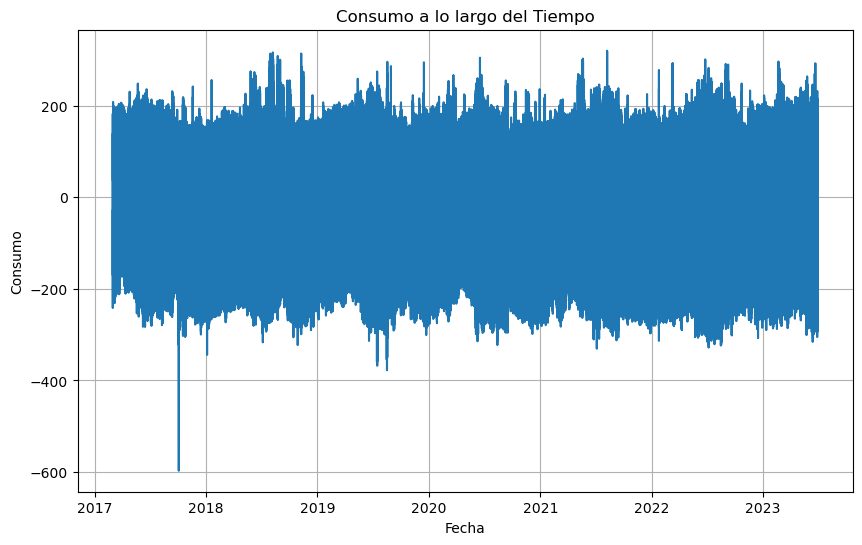

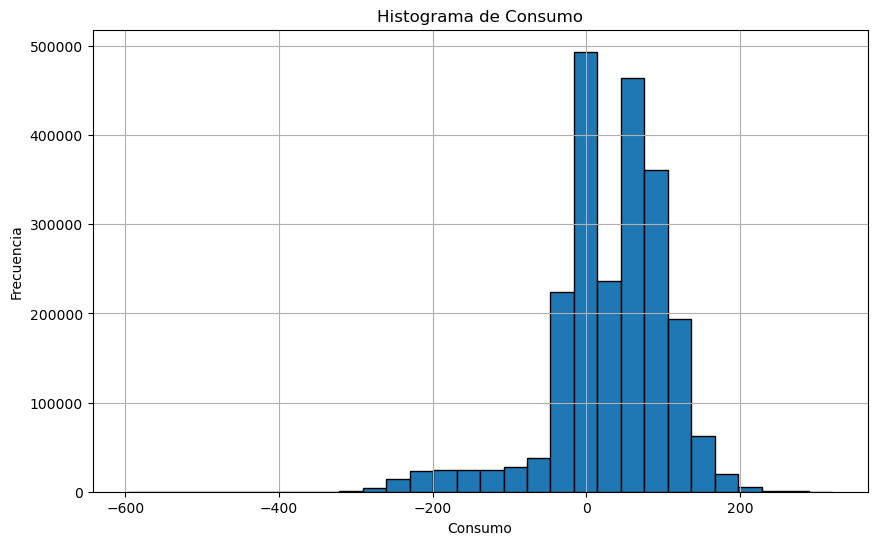

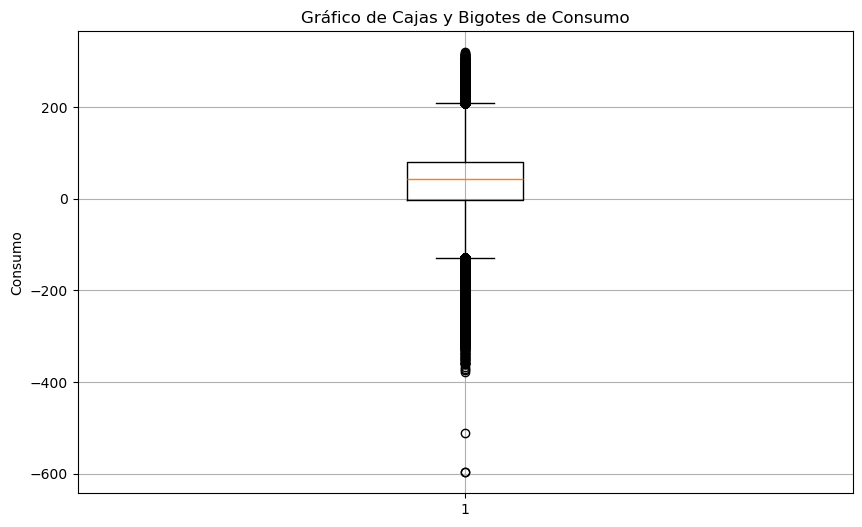

In [12]:
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

    # Gráfico de Líneas de Consumo a lo largo del Tiempo
plt.figure(figsize=(10, 6))
plt.plot(df['fecha'], df['consumo'])
plt.title('Consumo a lo largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.show()

    # Histograma de Consumo
plt.figure(figsize=(10, 6))
plt.hist(df['consumo'], bins=30, edgecolor='black')
plt.title('Histograma de Consumo')
plt.xlabel('Consumo')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

    # Gráfico de Cajas y Bigotes de Consumo
plt.figure(figsize=(10, 6))
plt.boxplot(df['consumo'])
plt.title('Gráfico de Cajas y Bigotes de Consumo')
plt.ylabel('Consumo')
plt.grid(True)
plt.show()



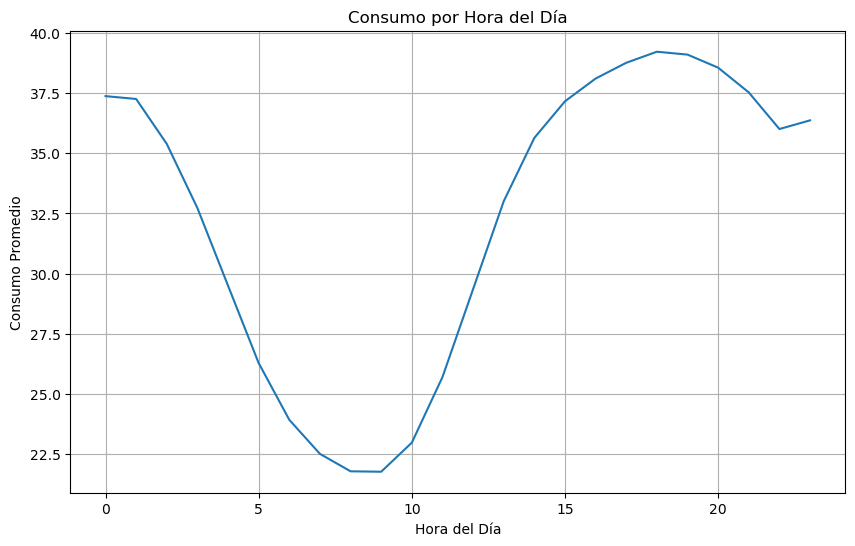

In [13]:

# Gráfico de Consumo por Hora del Día
plt.figure(figsize=(10, 6))
df.groupby('hora')['consumo'].mean().plot(kind='line')
plt.title('Consumo por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Consumo Promedio')
plt.grid(True)
plt.show()


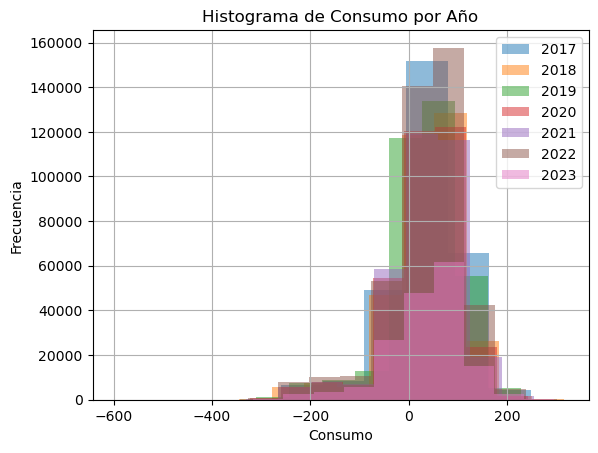

In [14]:

# Agrupar el DataFrame por año
df_por_año = df.groupby('año')['consumo'].agg(list)

# Crear el histograma para cada año
for año, consumos in df_por_año.items():
    plt.hist(consumos, alpha=0.5, label=str(año))

# Configurar el gráfico
plt.title('Histograma de Consumo por Año')
plt.xlabel('Consumo')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\luisa\anaconda3\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


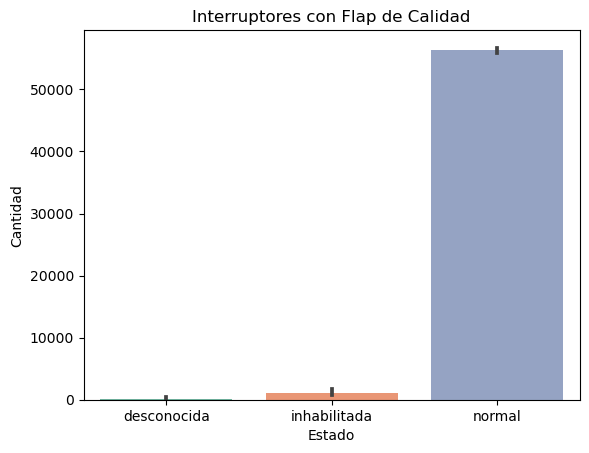

In [15]:

# Agrupar el DataFrame por nombre_interruptor y flap_de_calidad
df_flap = df.groupby(['nombre_interruptor', 'flap_de_calidad']).size().unstack()

# Crear un gráfico de barras apiladas
sns.barplot(data=df_flap, palette='Set2')

# Configurar el gráfico
plt.title('Interruptores con Flap de Calidad')
plt.xlabel('Estado')
plt.ylabel('Cantidad')
plt.show()

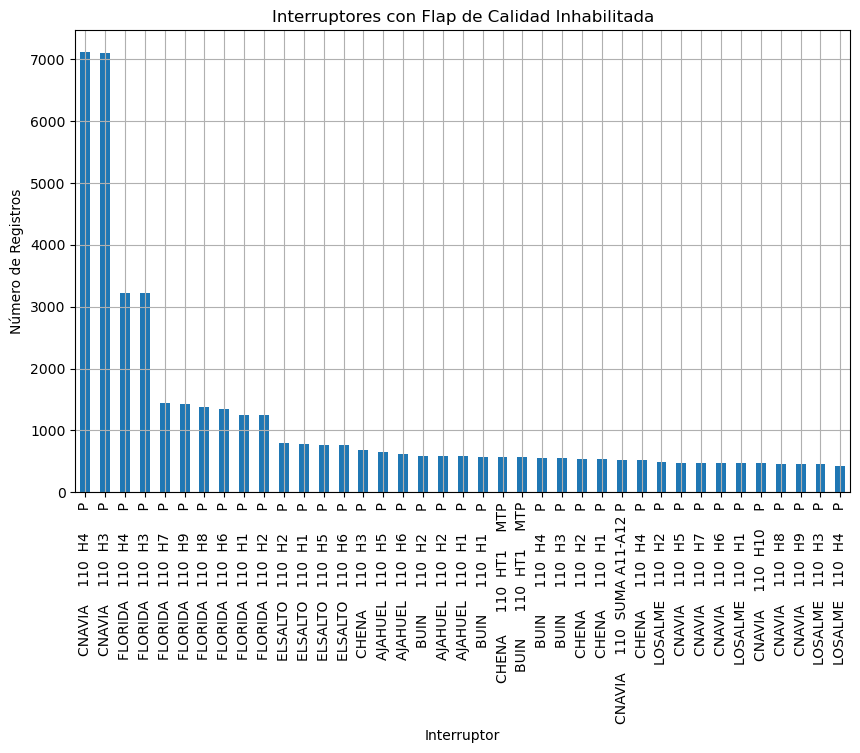

In [16]:

# Agrupar el DataFrame por nombre_interruptor y flap_de_calidad
df_agrupado = df.groupby(['nombre_interruptor', 'flap_de_calidad']).size().unstack()

# Obtener los interruptores con flap_de_calidad inhabilitada
interruptores_inhabilitados = df_agrupado['inhabilitada'].sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
interruptores_inhabilitados.plot.bar()
plt.title('Interruptores con Flap de Calidad Inhabilitada')
plt.xlabel('Interruptor')
plt.ylabel('Número de Registros')
plt.grid(True)
plt.show()

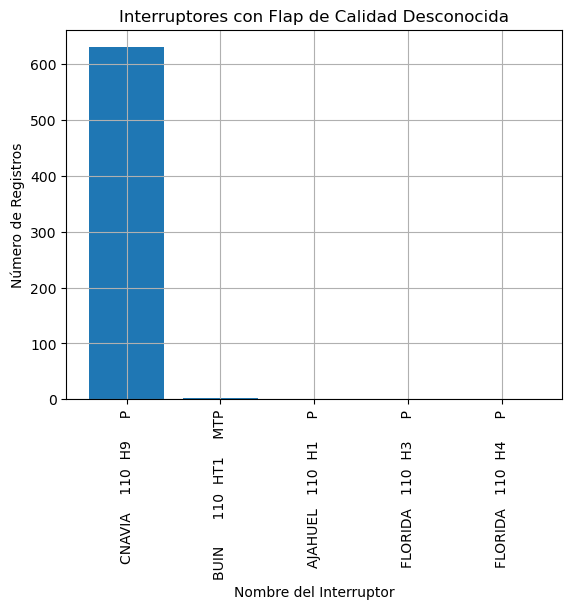

In [17]:

df_filtrado = df[df['flap_de_calidad'].isin(['desconocida'])]

# Obtener los nombres de los interruptores únicos
interruptores_filtrados = df_filtrado['nombre_interruptor'].unique()

# Crear el gráfico de barras
plt.bar(interruptores_filtrados, df_filtrado.groupby('nombre_interruptor')['flap_de_calidad'].count())

# Configurar el gráfico
plt.title('Interruptores con Flap de Calidad Desconocida')
plt.xlabel('Nombre del Interruptor')
plt.ylabel('Número de Registros')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

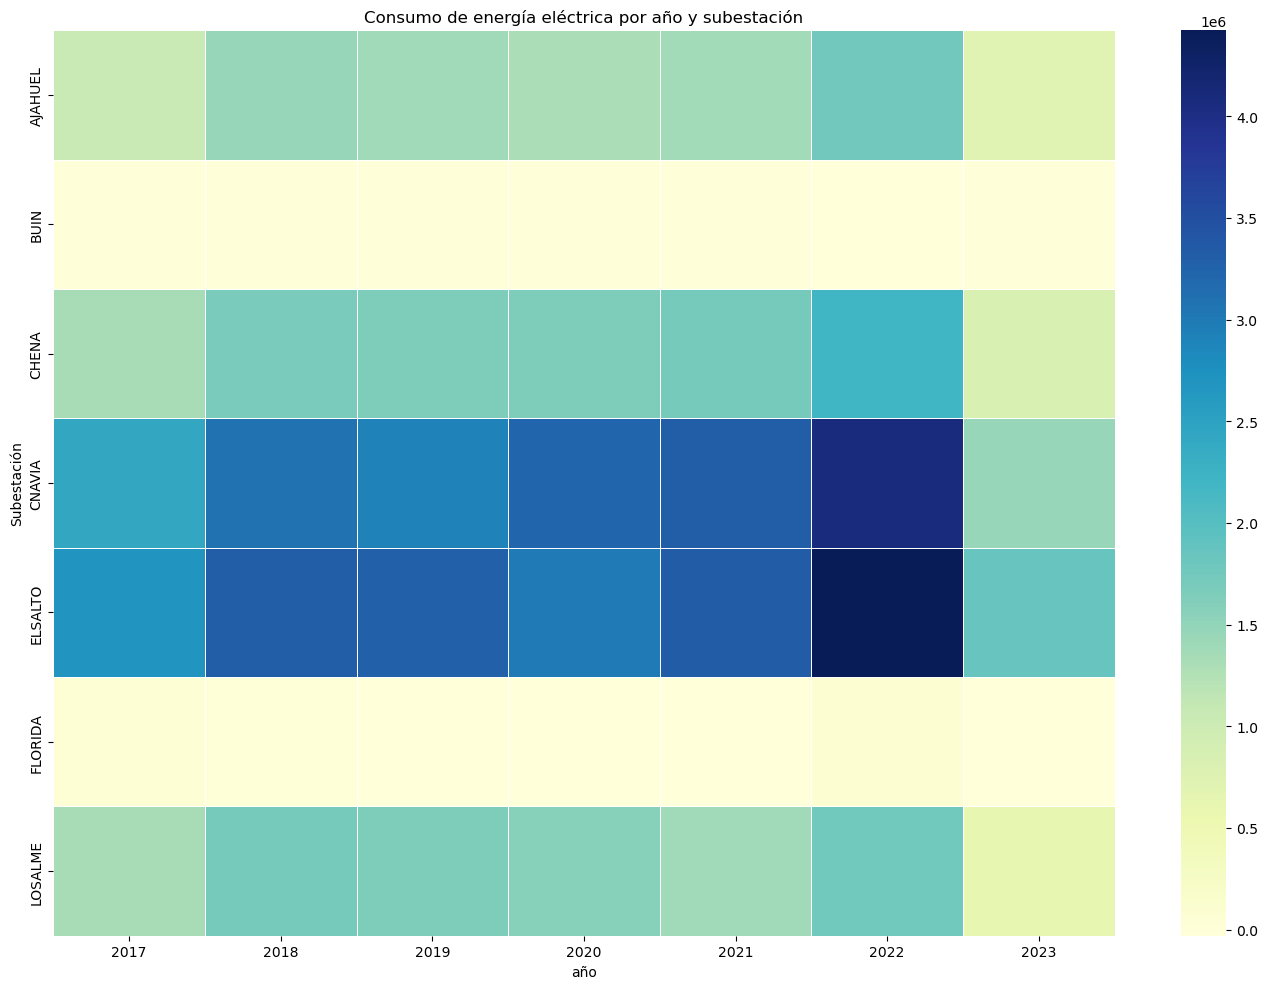

In [18]:

# Pivotar los datos para tener las subestaciones como índices, los años como columnas y el consumo como valores
consumption_pivot = df.pivot_table(index='Subestaciones', columns='año', values='consumo', aggfunc='sum')

# Crear el mapa de calor
plt.figure(figsize=(14, 10))
sns.heatmap(consumption_pivot, cmap='YlGnBu', linewidths=0.5)
plt.title('Consumo de energía eléctrica por año y subestación')
plt.xlabel('año')
plt.ylabel('Subestación')
plt.tight_layout()

# Mostrar el mapa de calor
plt.show()


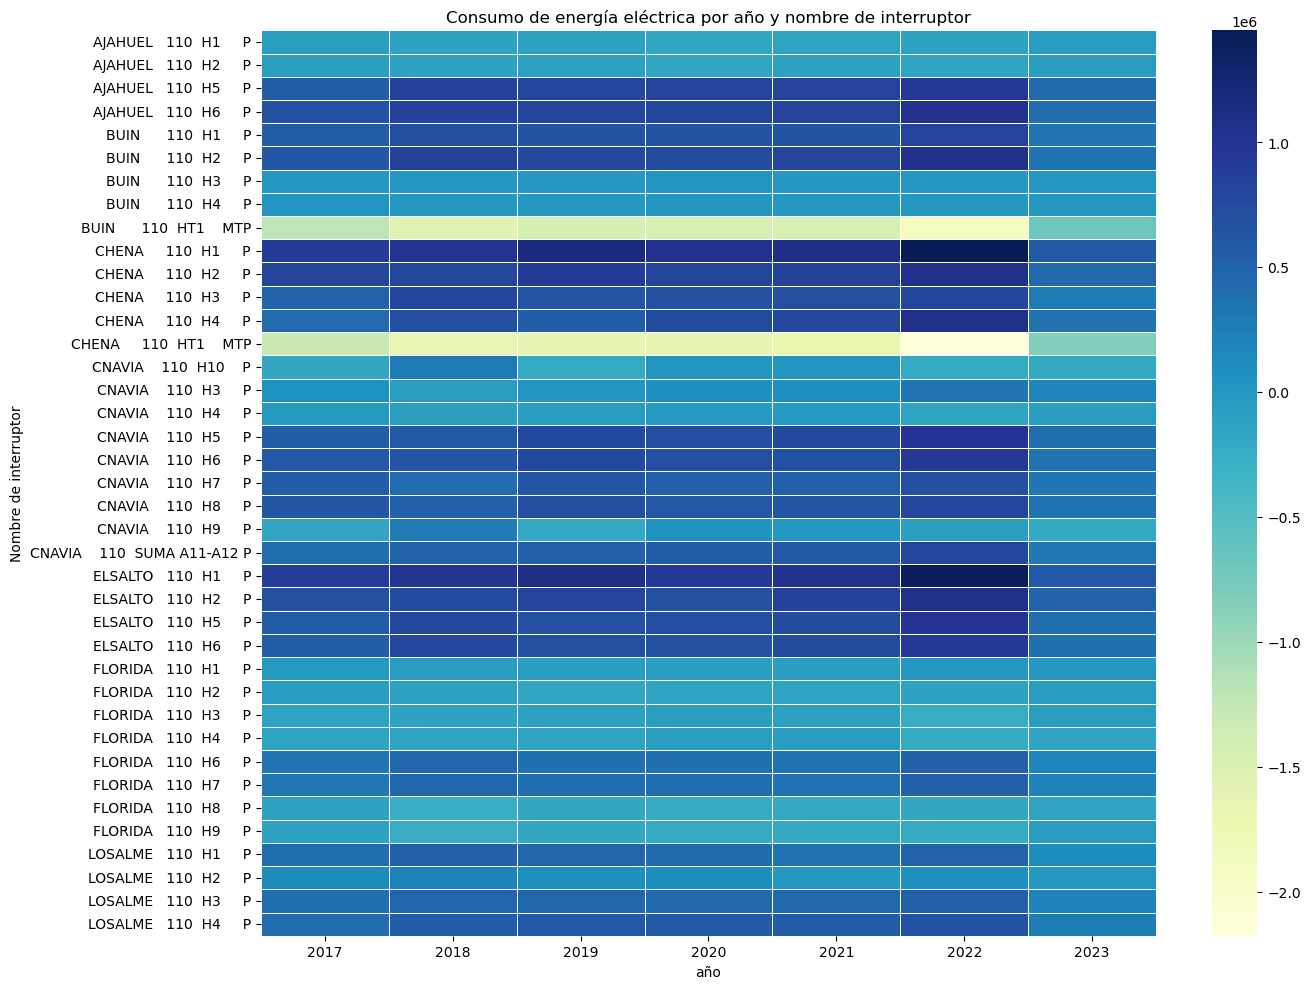

In [19]:

# Pivotar los datos para tener los nombres de interruptores como índices, las horas como columnas y el consumo como valores
interruptor_consumption_pivot = df.pivot_table(index='nombre_interruptor', columns='año', values='consumo', aggfunc='sum')

# Crear el mapa de calor
plt.figure(figsize=(14, 10))
sns.heatmap(interruptor_consumption_pivot, cmap='YlGnBu', linewidths=0.5)
plt.title('Consumo de energía eléctrica por año y nombre de interruptor')
plt.xlabel('año')
plt.ylabel('Nombre de interruptor')
plt.tight_layout()

# Mostrar el mapa de calor
plt.show()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2242968 entries, 0 to 2242967
Data columns (total 11 columns):
 #   Column              Dtype              
---  ------              -----              
 0   id                  int64              
 1   fecha               datetime64[ns, UTC]
 2   consumo             float64            
 3   flap_de_calidad     object             
 4   promedio_horas      int64              
 5   nombre_interruptor  object             
 6   dia                 int32              
 7   mes                 int32              
 8   año                 int32              
 9   hora                int32              
 10  Subestaciones       object             
dtypes: datetime64[ns, UTC](1), float64(1), int32(4), int64(2), object(3)
memory usage: 154.0+ MB


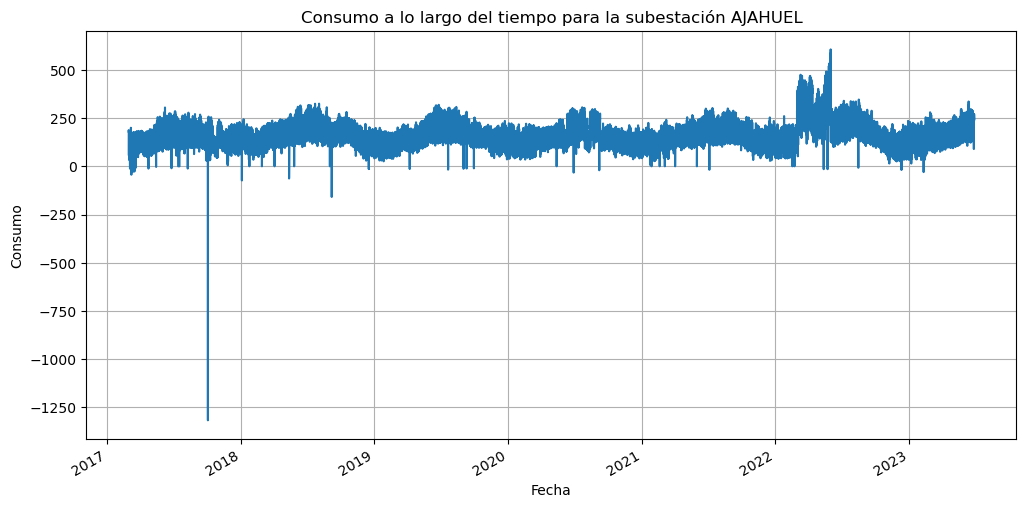

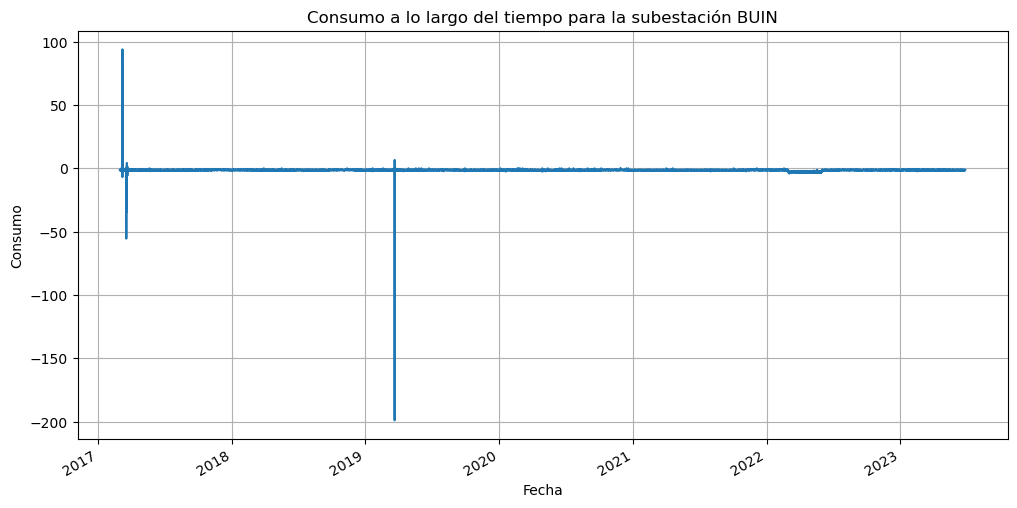

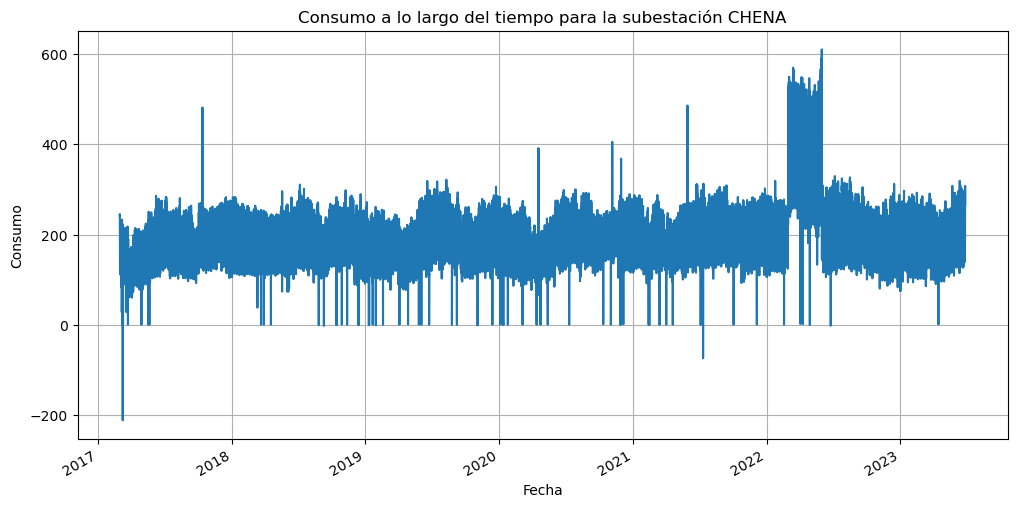

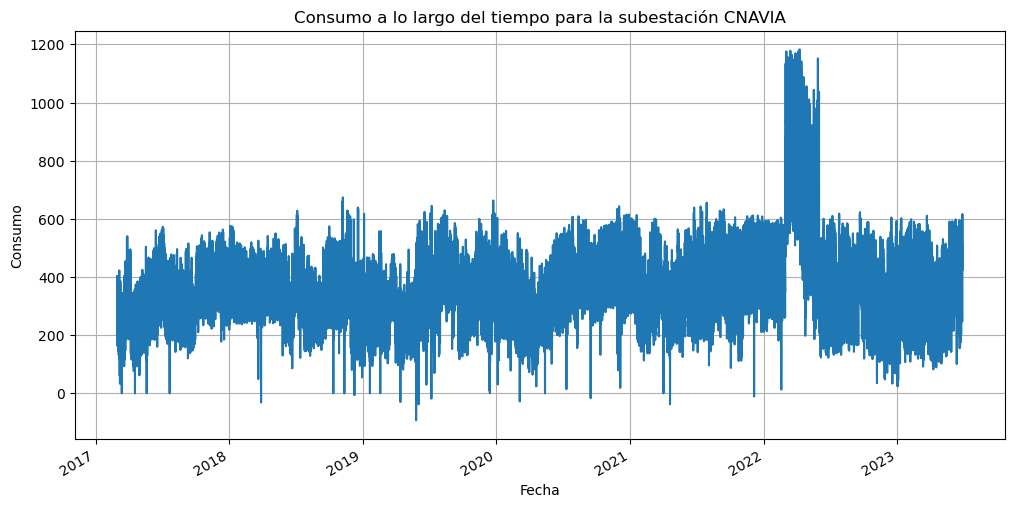

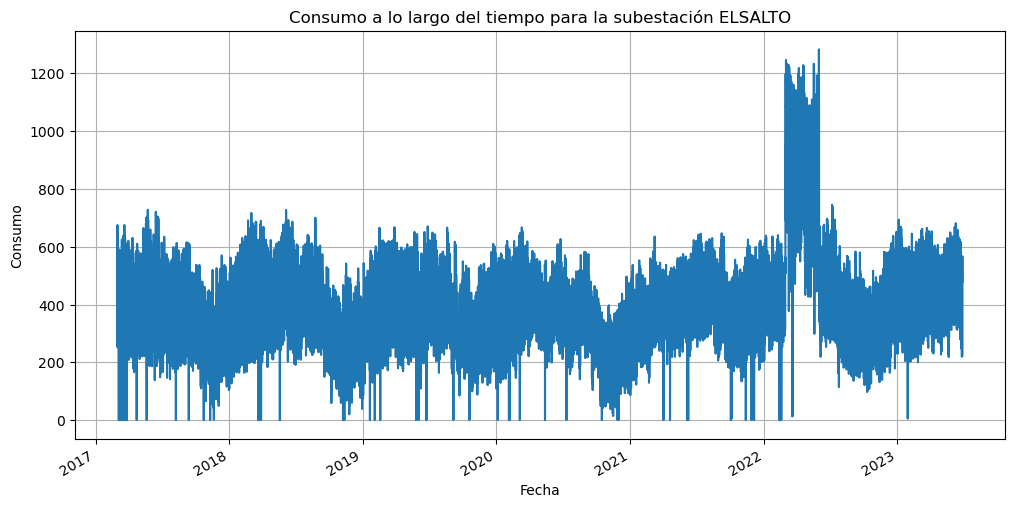

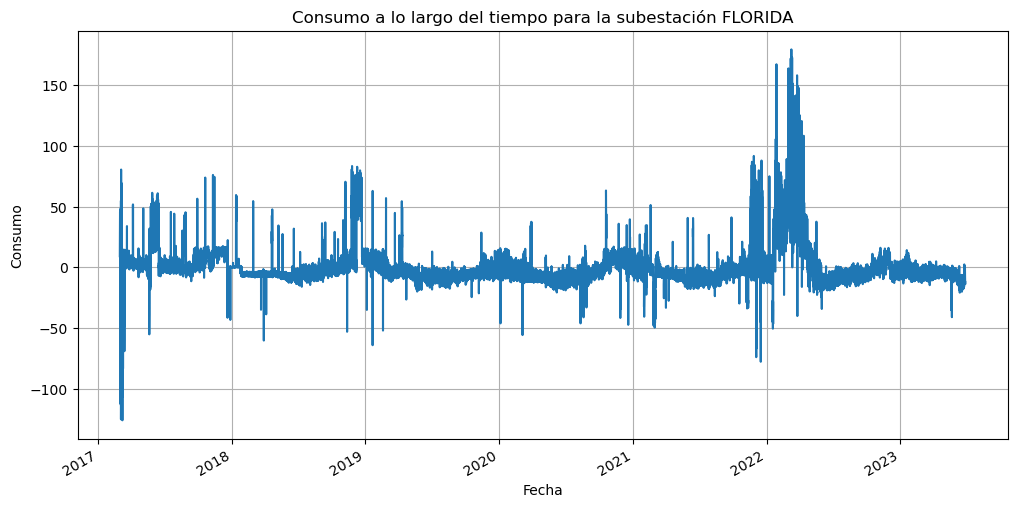

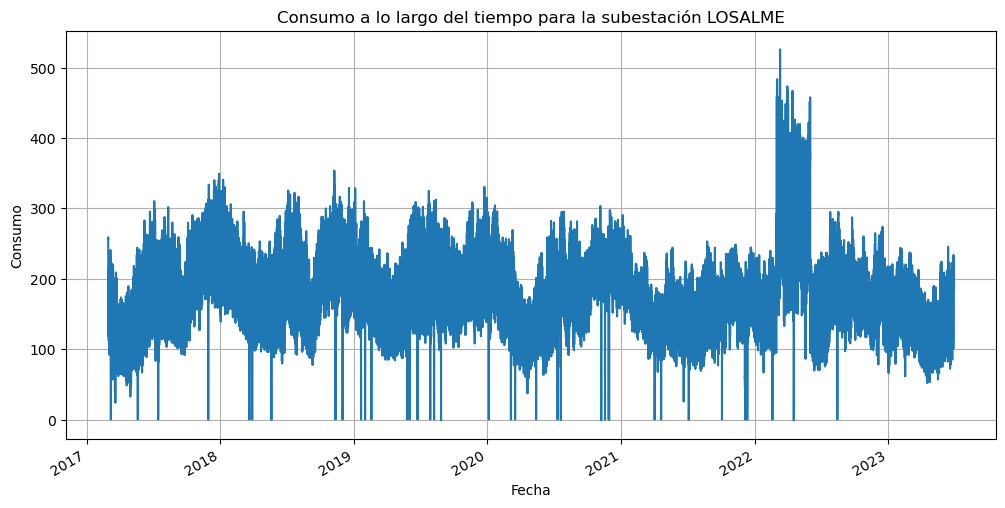

In [21]:
subestaciones = ["AJAHUEL", "BUIN", "CHENA", "CNAVIA", "ELSALTO", "FLORIDA", "LOSALME"]

for subestacion in subestaciones:
    # Filtrar por la subestación actual
    df_subestacion = df[df['Subestaciones'] == subestacion]
    
    # Agrupar por fecha y calcular el consumo total
    consumo_por_fecha = df_subestacion.groupby('fecha')['consumo'].sum()
    
    # Graficar la serie de tiempo para la subestación actual
    plt.figure(figsize=(12, 6))
    consumo_por_fecha.plot()
    plt.title(f'Consumo a lo largo del tiempo para la subestación {subestacion}')
    plt.xlabel('Fecha')
    plt.ylabel('Consumo')
    plt.grid(True)
    plt.show()

<Figure size 1200x600 with 0 Axes>

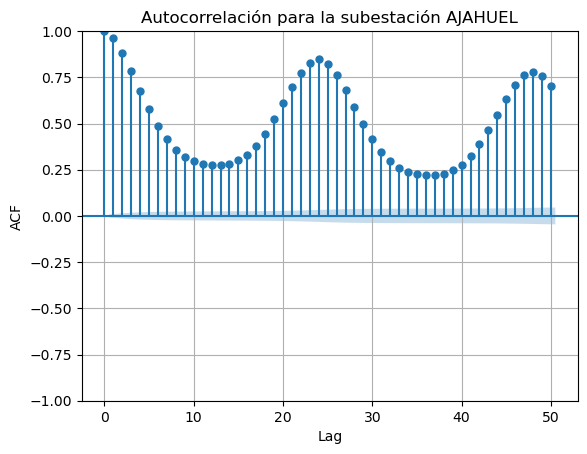

<Figure size 1200x600 with 0 Axes>

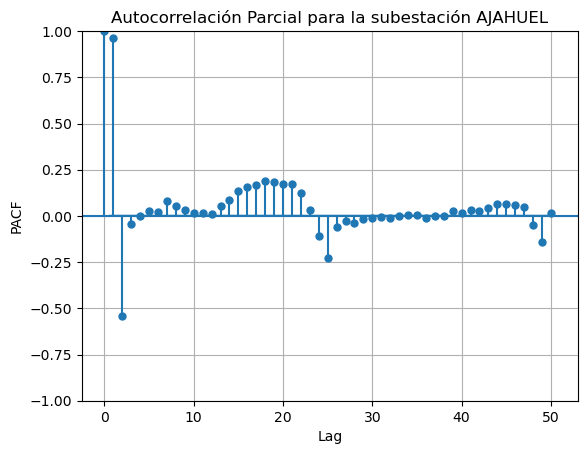

<Figure size 1200x600 with 0 Axes>

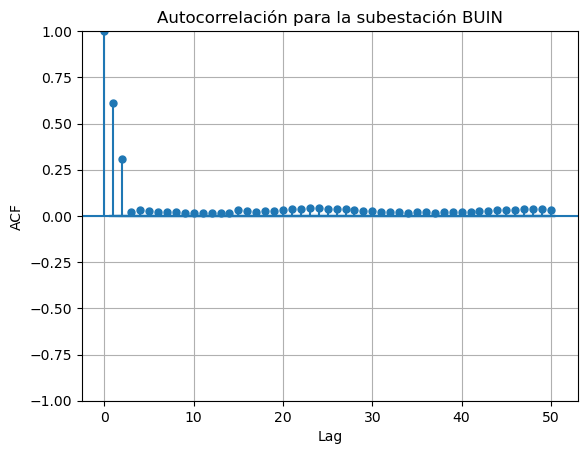

<Figure size 1200x600 with 0 Axes>

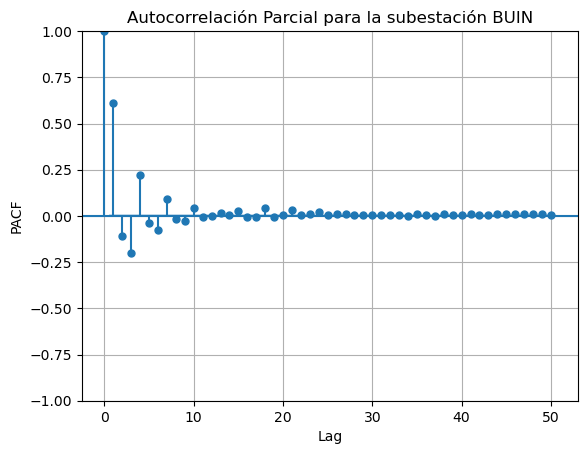

<Figure size 1200x600 with 0 Axes>

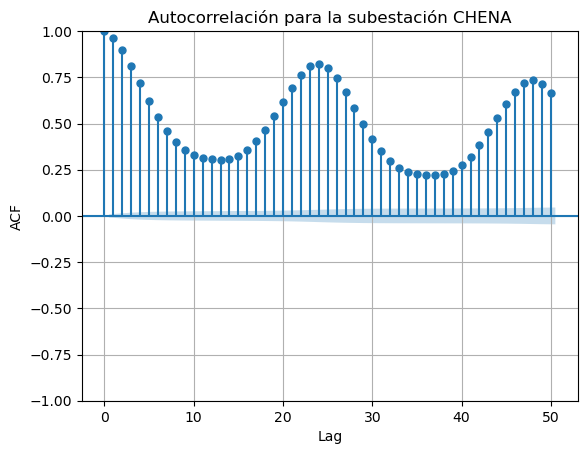

<Figure size 1200x600 with 0 Axes>

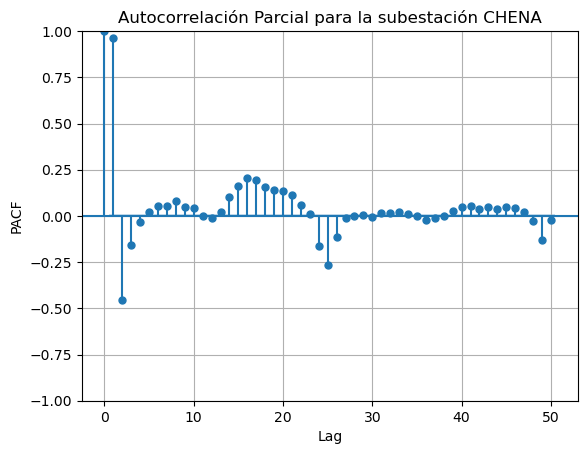

<Figure size 1200x600 with 0 Axes>

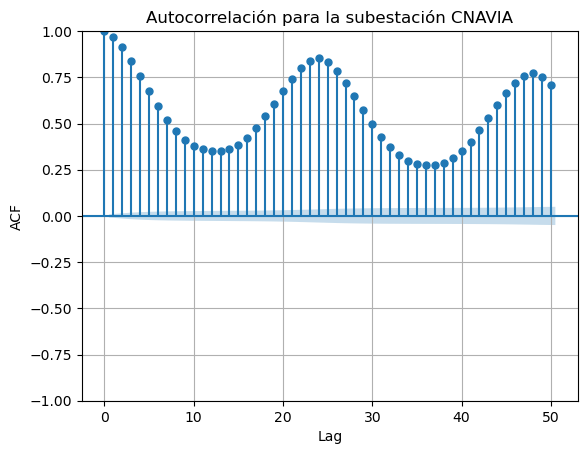

<Figure size 1200x600 with 0 Axes>

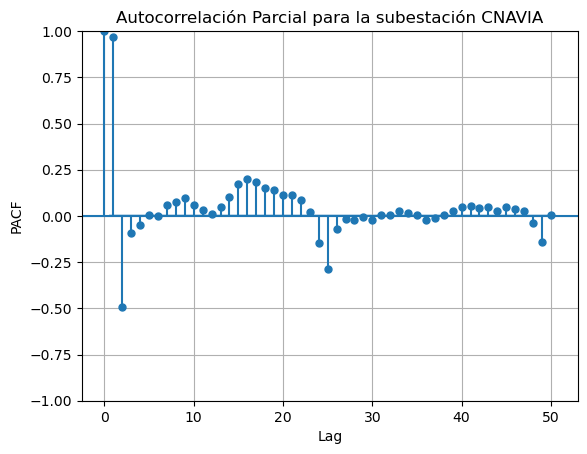

<Figure size 1200x600 with 0 Axes>

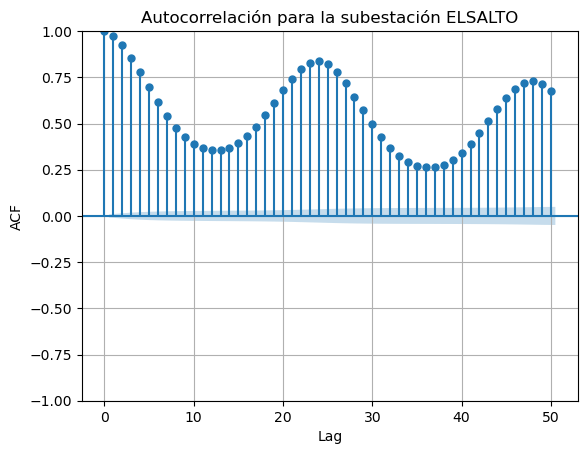

<Figure size 1200x600 with 0 Axes>

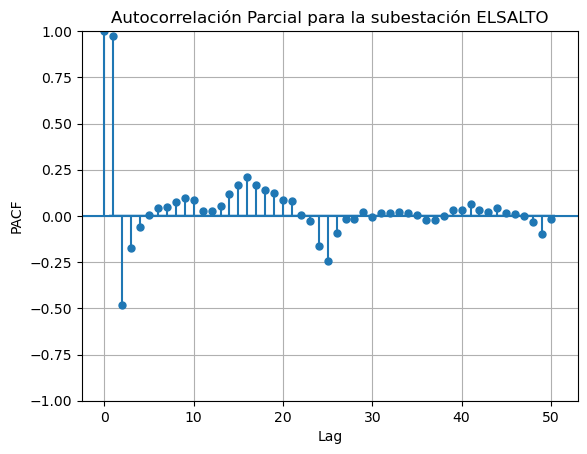

<Figure size 1200x600 with 0 Axes>

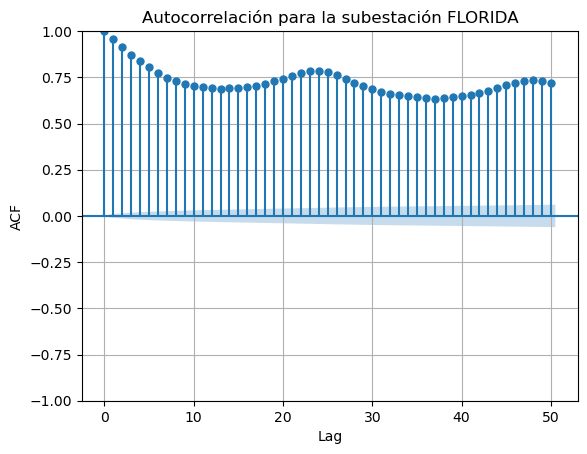

<Figure size 1200x600 with 0 Axes>

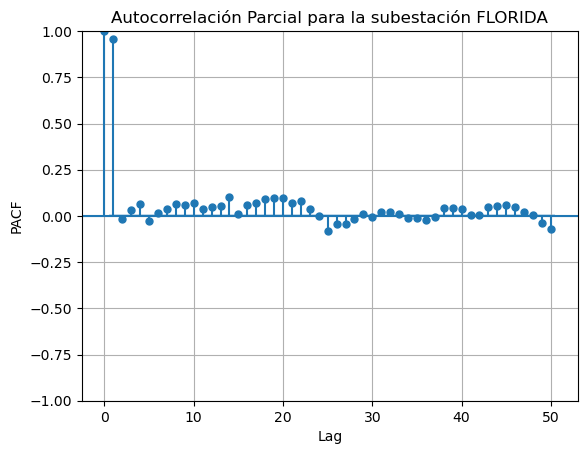

<Figure size 1200x600 with 0 Axes>

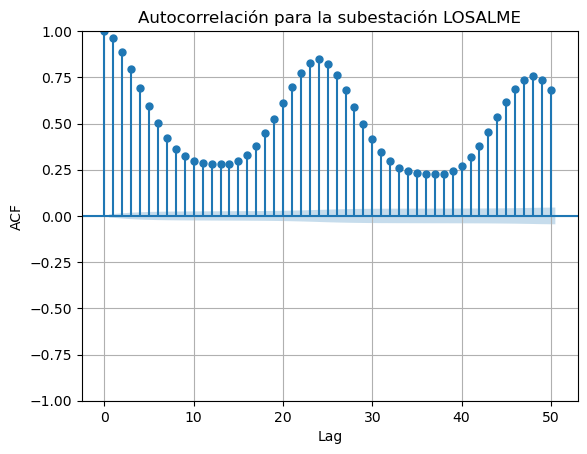

<Figure size 1200x600 with 0 Axes>

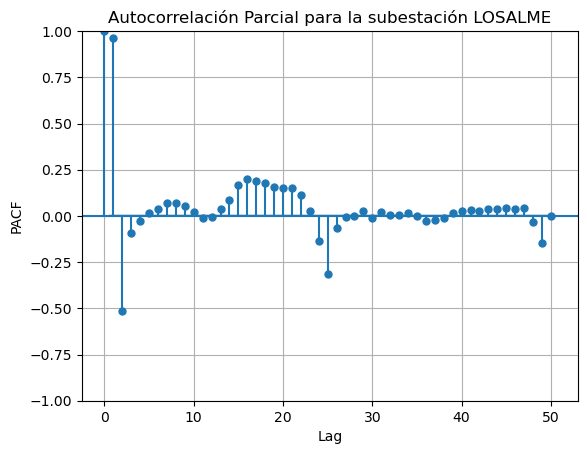

In [22]:
subestaciones = ["AJAHUEL", "BUIN", "CHENA", "CNAVIA", "ELSALTO", "FLORIDA", "LOSALME"]

for subestacion in subestaciones:
    # Filtrar por la subestación actual
    df_subestacion = df[df['Subestaciones'] == subestacion]
    
    # Agrupar por fecha y calcular el consumo total
    consumo_por_fecha = df_subestacion.groupby('fecha')['consumo'].sum()
    
    # Graficar la autocorrelación
    plt.figure(figsize=(12, 6))
    plot_acf(consumo_por_fecha, lags=50, title=f'Autocorrelación para la subestación {subestacion}')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.grid(True)
    plt.show()
    
    # Graficar la autocorrelación parcial
    plt.figure(figsize=(12, 6))
    plot_pacf(consumo_por_fecha, lags=50, title=f'Autocorrelación Parcial para la subestación {subestacion}')
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    plt.grid(True)
    plt.show()

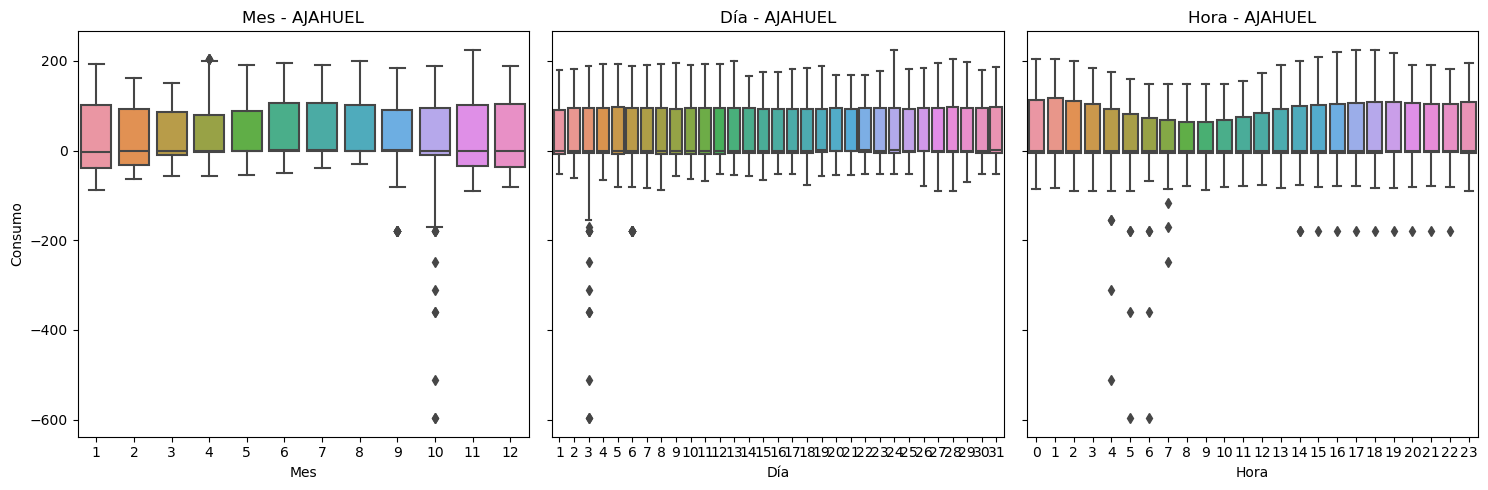

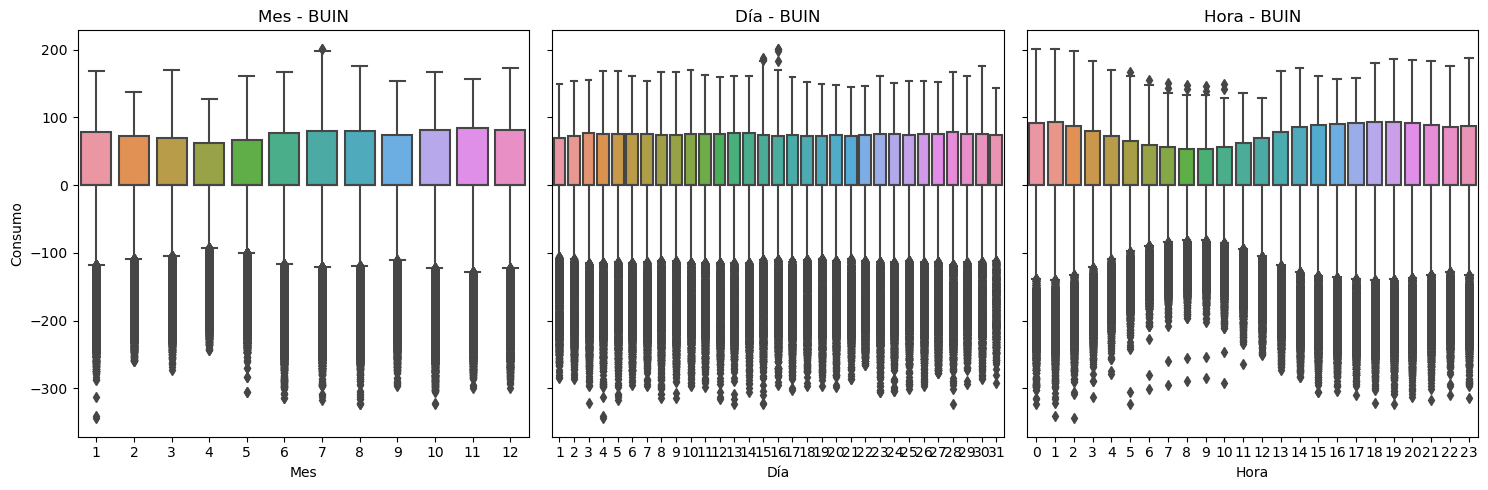

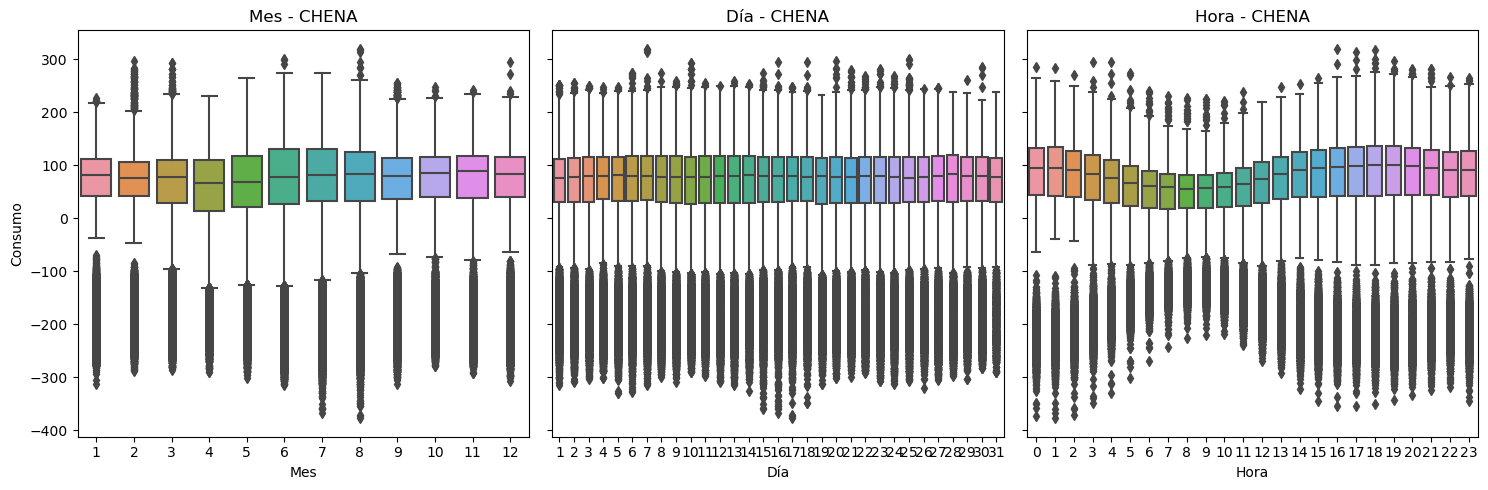

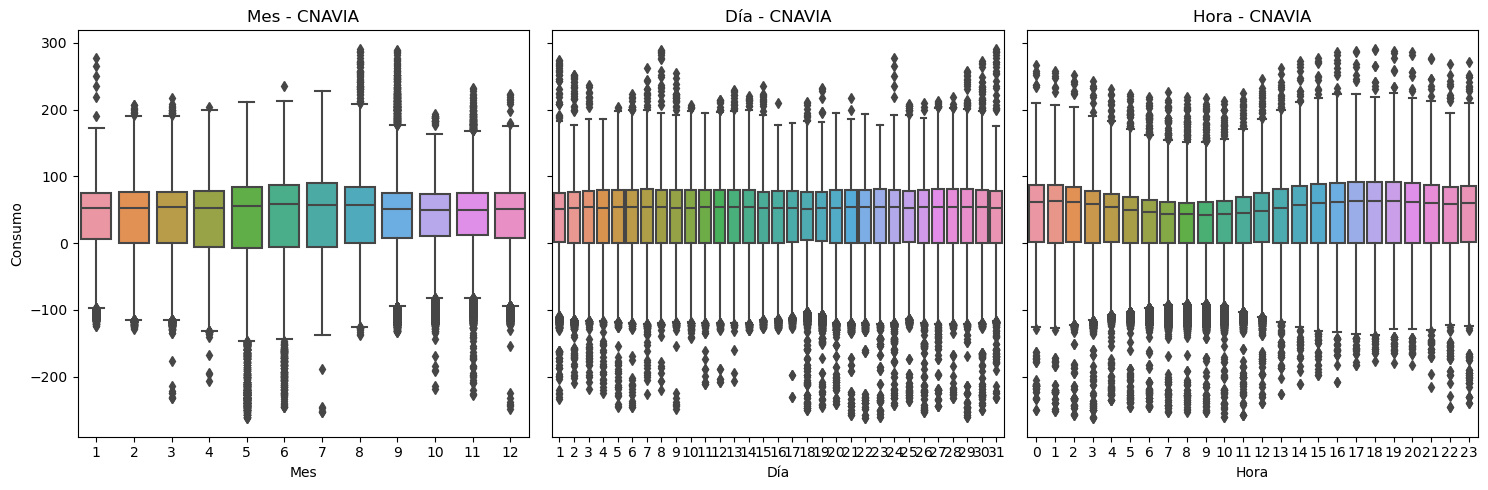

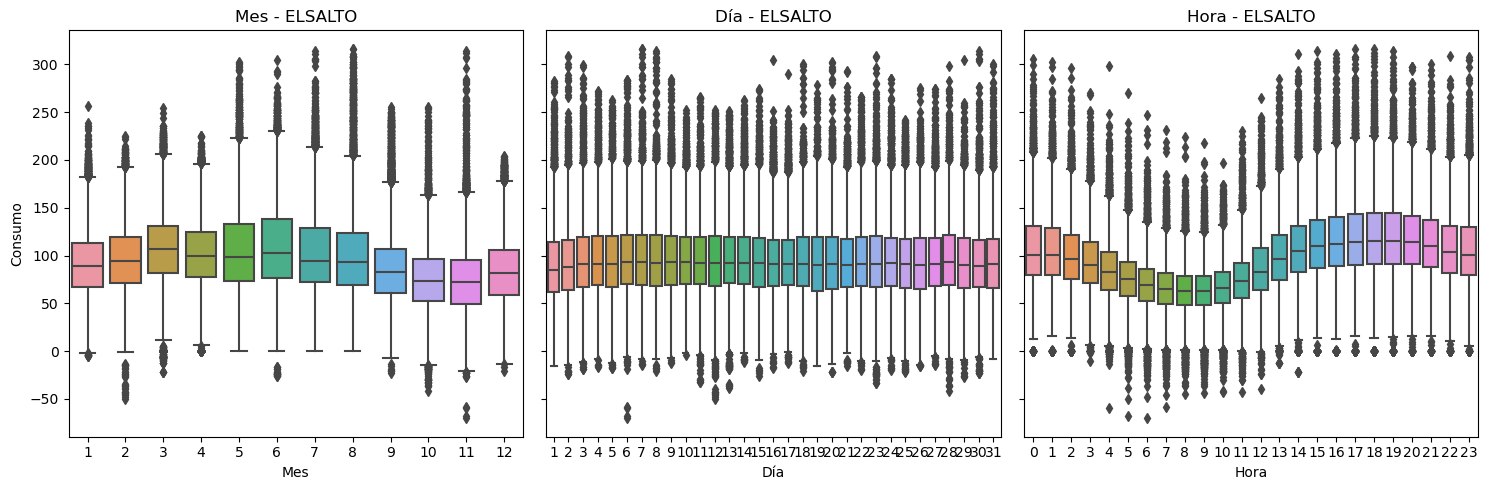

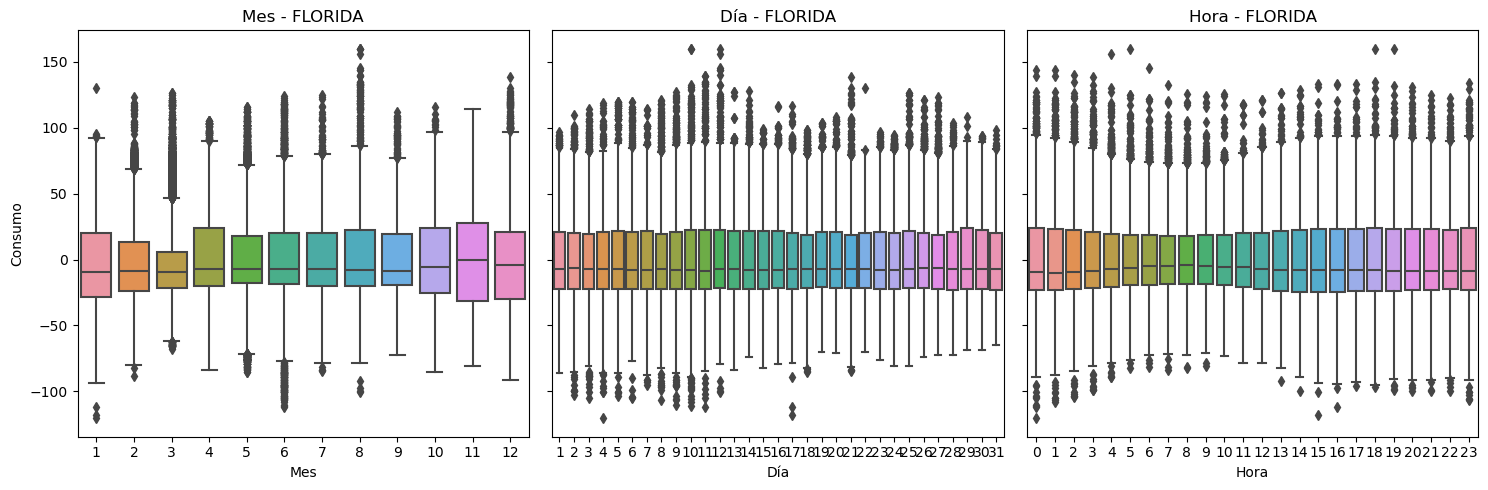

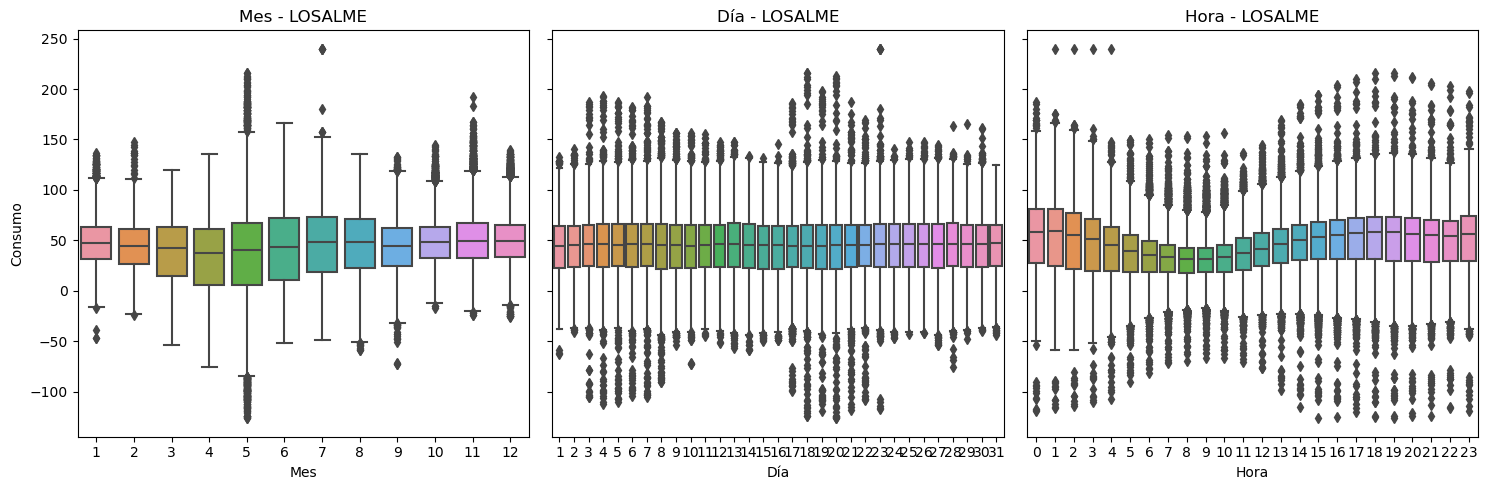

In [23]:
subestaciones = ["AJAHUEL", "BUIN", "CHENA", "CNAVIA", "ELSALTO", "FLORIDA", "LOSALME"]

for subestacion in subestaciones:
    # Filtrar por la subestación actual
    df_subestacion = df[df['Subestaciones'] == subestacion]
    
    # Crear un DataFrame con las columnas de interés (mes, día y hora)
    df_temporal = df_subestacion[['fecha', 'consumo']].copy()
    df_temporal['day'] = df_temporal['fecha'].dt.day
    df_temporal['hour'] = df_temporal['fecha'].dt.hour
    df_temporal['month'] = df_temporal['fecha'].dt.month
    
    # Creamos una figura con subgráficos para cada subestación
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey='row')

    # Graficar el boxplot para cada columna
    sns.boxplot(x="month", y="consumo", data=df_temporal, ax=axes[0])
    axes[0].set_title(f'Mes - {subestacion}')
    axes[0].set_xlabel('Mes')
    axes[0].set_ylabel('Consumo')
    
    sns.boxplot(x="day", y="consumo", data=df_temporal, ax=axes[1])
    axes[1].set_title(f'Día - {subestacion}')
    axes[1].set_xlabel('Día')
    axes[1].set_ylabel('')
    
    sns.boxplot(x="hour", y="consumo", data=df_temporal, ax=axes[2])
    axes[2].set_title(f'Hora - {subestacion}')
    axes[2].set_xlabel('Hora')
    axes[2].set_ylabel('')

    plt.tight_layout()
    plt.show()

In [24]:
for subestacion in subestaciones:
    # Filtrar por la subestación actual
    df_subestacion = df[df['Subestaciones'] == subestacion]
    
    # Seleccionar las columnas deseadas
    df_subestacion = df_subestacion[['Subestaciones', 'dia', 'mes', 'año', 'hora', 'fecha', 'consumo']]
    
    # Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
    train, test = train_test_split(df_subestacion, test_size=0.2, random_state=42)
    
    # Guardar los conjuntos de datos en archivos CSV separados
    train.to_csv(f"{subestacion}_train.csv", index=False)
    test.to_csv(f"{subestacion}_test.csv", index=False)

In [27]:
ds_train=pd.read_csv("AJAHUEL_train.csv")
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184038 entries, 0 to 184037
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Subestaciones  184038 non-null  object 
 1   dia            184038 non-null  int64  
 2   mes            184038 non-null  int64  
 3   año            184038 non-null  int64  
 4   hora           184038 non-null  int64  
 5   fecha          184038 non-null  object 
 6   consumo        184038 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 9.8+ MB


In [26]:

for subestacion in subestaciones:
    # Cargar el conjunto de entrenamiento para la subestación actual
    train = pd.read_csv(f"{subestacion}_train.csv")
    
    # Seleccionar la columna relevante para el análisis
    data = train[['consumo']]
    
    # Normalizar los datos
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(data)
    
    # Aplicar el algoritmo de KNN para detectar valores atípicos
    lof = LocalOutlierFactor(n_neighbors=20)  # Puedes ajustar el número de vecinos según tu necesidad
    outliers = lof.fit_predict(data_normalized)
    
    # Identificar los índices de los valores atípicos
    outliers_indices = outliers == -1
    
    # Sustituir los valores atípicos por el valor promedio
    mean_consumption = train['consumo'].mean()
    train.loc[outliers_indices, 'consumo'] = mean_consumption
    
    # Guardar el conjunto de datos corregido en un archivo CSV
    train.to_csv(f"{subestacion}_train_corrected.csv", index=False)

C:\Users\luisa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 73s 23ms/step - loss: 3642.4998 - val_loss: 3388.9729
Epoch 2/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 66s 23ms/step - loss: 3319.7456 - val_loss: 3388.5813
Epoch 3/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 67s 23ms/step - loss: 2946.3784 - val_loss: 320.0450
Epoch 4/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 67s 23ms/step - loss: 289.5589 - val_loss: 184.6159
Epoch 5/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 68s 24ms/step - loss: 191.1137 - val_loss: 128.7250
Epoch 6/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 66s 23ms/step - loss: 133.7457 - val_loss: 79.5858
Epoch 7/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 65s 22ms/step - loss: 101.1559 - val_loss: 56.7799
Epoch 8/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 65s 23ms/step - loss: 84.5617 - val_loss: 40.6849
Epoch 9/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 68s 24ms/step - loss: 75.6304 - val_loss: 46.6318
Epoch 10/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 69s 24ms/step - loss: 69.1456 - val_loss: 29.7774
Epoch 11/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 64s 22ms/step - los

MSE: 16.909559515404496
MAE: 2.0243626723566726


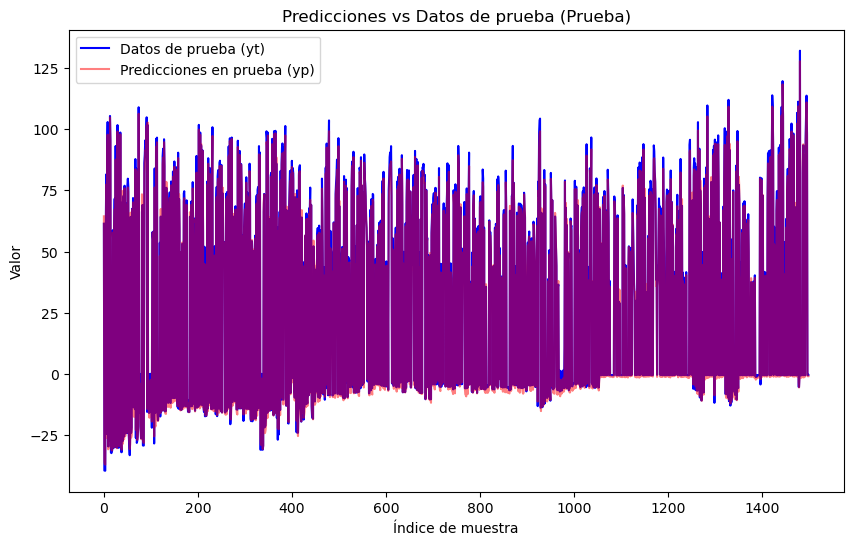

In [28]:
# Cargar los datos de entrenamiento y prueba desde los archivos CSV
train_data = pd.read_csv("AJAHUEL_train_corrected.csv")
test_data = pd.read_csv("AJAHUEL_test.csv")

# Definir el tamaño de la ventana temporal (por ejemplo, 24 horas)
window_size = 24

# Función para preparar los datos para el modelo RNN
def prepare_data(data):
    # Ordenar los datos por fecha y hora
    data['fecha'] = pd.to_datetime(data['fecha'])
    data = data.sort_values(by='fecha')

    # Crear secuencias temporales deslizantes
    sequences = []
    for i in range(len(data) - window_size):
        sequence = data.iloc[i:i+window_size]
        sequences.append(sequence)

    # Crear conjuntos de características (X) y etiquetas (y) para cada secuencia temporal
    X = []
    y = []
    for sequence in sequences:
        X.append(sequence[['dia', 'mes', 'año', 'hora', 'consumo']].values)  # Tomar las características de día, mes, año, hora y consumo
        y.append(sequence.iloc[-1]['consumo'])  # Tomar el último valor de consumo como etiqueta de salida

    X = np.array(X)
    y = np.array(y)

    return X, y

# Preparar los datos de entrenamiento y prueba
X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

# Normalizar los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

# Reshape de los datos para que tengan la forma adecuada para LSTM
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], window_size, 5)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], window_size, 5)

# Construir el modelo RNN
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(window_size, 5)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compilar el modelo con el optimizador Adam y una tasa de aprendizaje de 1e-3
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo con 50 epochs
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=64, validation_data=(X_test_reshaped, y_test))

# Evaluar el modelo
loss = model.evaluate(X_test_reshaped, y_test)
print(f"Loss: {loss}")

# Obtener las predicciones en el conjunto de prueba
yp_test = model.predict(X_test_reshaped)

# Calcular las métricas adicionales: MSE, MAE 
mse = mean_squared_error(y_test, yp_test)
mae = mean_absolute_error(y_test, yp_test)
print(f"MSE: {mse}")
print(f"MAE: {mae}")
model.save("modelo_entrenado_AJAHUEL.h5")
# Crear una secuencia de índices limitada para el conjunto de prueba (por ejemplo, las primeras 1500 muestras)
xw_test_limited = [i for i in range(1500)]

# Limitar las predicciones del conjunto de prueba a las primeras 1500 muestras
yp_test_limited = yp_test[:1500]

# Graficar los datos de prueba y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(xw_test_limited, y_test[:1500], label='Datos de prueba (yt)', color='blue')
plt.plot(xw_test_limited, yp_test_limited, label='Predicciones en prueba (yp)', color='red', alpha=0.5)  # Color rojo transparente
plt.xlabel('Índice de muestra')
plt.ylabel('Valor')
plt.title('Predicciones vs Datos de prueba (Prueba)')
plt.legend()
plt.show()

Epoch 1/25


C:\Users\luisa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 91s 24ms/step - loss: 8158.0713 - val_loss: 1748.4833
Epoch 2/25
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 85s 24ms/step - loss: 1266.1182 - val_loss: 301.6962
Epoch 3/25
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 85s 24ms/step - loss: 344.6780 - val_loss: 106.5017
Epoch 4/25
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 85s 24ms/step - loss: 152.6617 - val_loss: 67.8216
Epoch 5/25
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 88s 25ms/step - loss: 117.8966 - val_loss: 79.0108
Epoch 6/25
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 86s 24ms/step - loss: 102.3191 - val_loss: 39.2982
Epoch 7/25
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 87s 24ms/step - loss: 94.8660 - val_loss: 31.0484
Epoch 8/25
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 88s 24ms/step - loss: 91.2058 - val_loss: 29.6513
Epoch 9/25
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 87s 24ms/step - loss: 88.1075 - val_loss: 24.6183
Epoch 10/25
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 86s 24ms/step - loss: 87.3162 - val_loss: 19.4696
Epoch 11/25
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 87s 24ms/step - loss: 86.9930 - val

MSE: 17.081983878781745
MAE: 2.5556722635438716


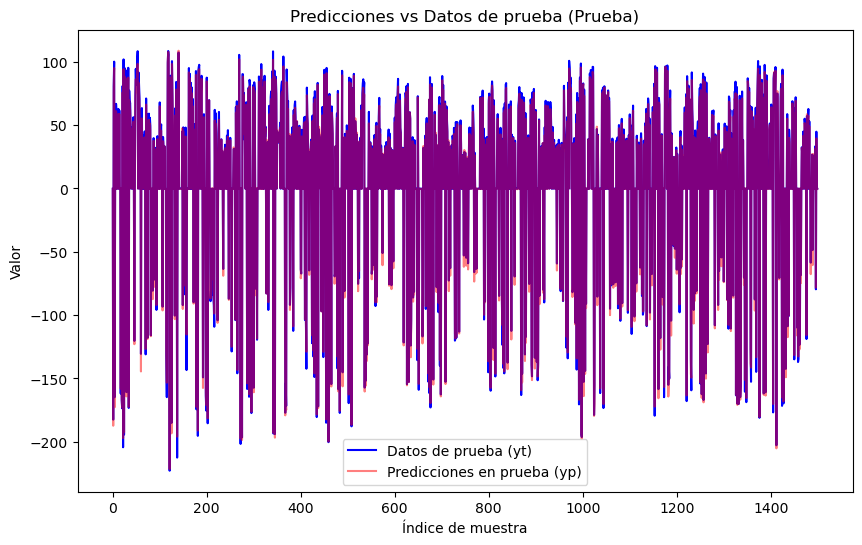

In [29]:
train_data = pd.read_csv("BUIN_train_corrected.csv")
test_data = pd.read_csv("BUIN_test.csv")

# Definir el tamaño de la ventana temporal (por ejemplo, 24 horas)
window_size = 24

# Función para preparar los datos para el modelo RNN
def prepare_data(data):
    # Ordenar los datos por fecha y hora
    data['fecha'] = pd.to_datetime(data['fecha'])
    data = data.sort_values(by='fecha')

    # Crear secuencias temporales deslizantes
    sequences = []
    for i in range(len(data) - window_size):
        sequence = data.iloc[i:i+window_size]
        sequences.append(sequence)

    # Crear conjuntos de características (X) y etiquetas (y) para cada secuencia temporal
    X = []
    y = []
    for sequence in sequences:
        X.append(sequence[['dia', 'mes', 'año', 'hora', 'consumo']].values)  # Tomar las características de día, mes, año, hora y consumo
        y.append(sequence.iloc[-1]['consumo'])  # Tomar el último valor de consumo como etiqueta de salida

    X = np.array(X)
    y = np.array(y)

    return X, y

# Preparar los datos de entrenamiento y prueba
X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

# Normalizar los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

# Reshape de los datos para que tengan la forma adecuada para LSTM
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], window_size, 5)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], window_size, 5)

# Construir el modelo RNN
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(window_size, 5)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compilar el modelo con el optimizador Adam y una tasa de aprendizaje de 1e-3
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo con 25 epochs
history = model.fit(X_train_reshaped, y_train, epochs=25, batch_size=64, validation_data=(X_test_reshaped, y_test))

# Evaluar el modelo
loss = model.evaluate(X_test_reshaped, y_test)
print(f"Loss: {loss}")

# Obtener las predicciones en el conjunto de prueba
yp_test = model.predict(X_test_reshaped)

# Calcular las métricas adicionales: MSE, MAE 
mse = mean_squared_error(y_test, yp_test)
mae = mean_absolute_error(y_test, yp_test)
print(f"MSE: {mse}")
print(f"MAE: {mae}")
model.save("modelo_entrenado_BUIN.h5")
# Crear una secuencia de índices limitada para el conjunto de prueba (por ejemplo, las primeras 1500 muestras)
xw_test_limited = [i for i in range(1500)]

# Limitar las predicciones del conjunto de prueba a las primeras 1500 muestras
yp_test_limited = yp_test[:1500]

# Graficar los datos de prueba y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(xw_test_limited, y_test[:1500], label='Datos de prueba (yt)', color='blue')
plt.plot(xw_test_limited, yp_test_limited, label='Predicciones en prueba (yp)', color='red', alpha=0.5)  # Color rojo transparente
plt.xlabel('Índice de muestra')
plt.ylabel('Valor')
plt.title('Predicciones vs Datos de prueba (Prueba)')
plt.legend()
plt.show()

Epoch 1/20


C:\Users\luisa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 92s 24ms/step - loss: 15225.0166 - val_loss: 14939.2979
Epoch 2/20
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 86s 24ms/step - loss: 14787.4521 - val_loss: 8454.6426
Epoch 3/20
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 86s 24ms/step - loss: 7967.8262 - val_loss: 7022.2949
Epoch 4/20
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 85s 24ms/step - loss: 6918.9385 - val_loss: 6471.8306
Epoch 5/20
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 85s 24ms/step - loss: 6459.2827 - val_loss: 5994.7012
Epoch 6/20
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 86s 24ms/step - loss: 5975.2178 - val_loss: 5553.6348
Epoch 7/20
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 92s 26ms/step - loss: 5580.6636 - val_loss: 5127.9644
Epoch 8/20
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 92s 25ms/step - loss: 5114.8667 - val_loss: 4725.3218
Epoch 9/20
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 87s 24ms/step - loss: 4737.9004 - val_loss: 4333.3433
Epoch 10/20
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 84s 23ms/step - loss: 4371.1401 - val_loss: 3969.5327
Epoch 11/20
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 84s 

MSE: 1332.1209414485131
MAE: 17.004632955291346


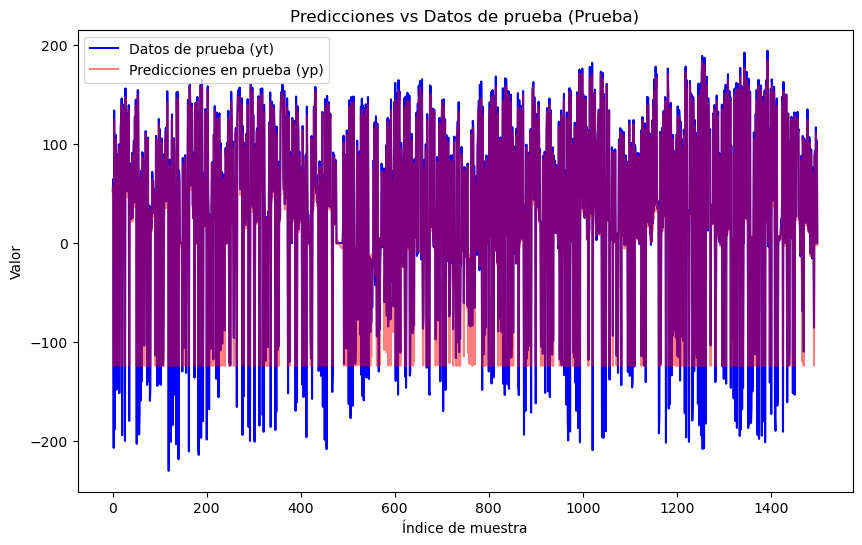

In [30]:
train_data = pd.read_csv("CHENA_train_corrected.csv")
test_data = pd.read_csv("CHENA_test.csv")

# Definir el tamaño de la ventana temporal (por ejemplo, 24 horas)
window_size = 24

# Función para preparar los datos para el modelo RNN
def prepare_data(data):
    # Ordenar los datos por fecha y hora
    data['fecha'] = pd.to_datetime(data['fecha'])
    data = data.sort_values(by='fecha')

    # Crear secuencias temporales deslizantes
    sequences = []
    for i in range(len(data) - window_size):
        sequence = data.iloc[i:i+window_size]
        sequences.append(sequence)

    # Crear conjuntos de características (X) y etiquetas (y) para cada secuencia temporal
    X = []
    y = []
    for sequence in sequences:
        X.append(sequence[['dia', 'mes', 'año', 'hora', 'consumo']].values)  # Tomar las características de día, mes, año, hora y consumo
        y.append(sequence.iloc[-1]['consumo'])  # Tomar el último valor de consumo como etiqueta de salida

    X = np.array(X)
    y = np.array(y)

    return X, y

# Preparar los datos de entrenamiento y prueba
X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

# Normalizar los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

# Reshape de los datos para que tengan la forma adecuada para LSTM
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], window_size, 5)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], window_size, 5)

# Construir el modelo RNN
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(window_size, 5)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compilar el modelo con el optimizador Adam y una tasa de aprendizaje de 1e-3
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo con 20 epochs
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=64, validation_data=(X_test_reshaped, y_test))

# Evaluar el modelo
loss = model.evaluate(X_test_reshaped, y_test)
print(f"Loss: {loss}")

# Obtener las predicciones en el conjunto de prueba
yp_test = model.predict(X_test_reshaped)

# Calcular las métricas adicionales: MSE, MAE 
mse = mean_squared_error(y_test, yp_test)
mae = mean_absolute_error(y_test, yp_test)
print(f"MSE: {mse}")
print(f"MAE: {mae}")
model.save("modelo_entrenado_CHENA.h5")
# Crear una secuencia de índices limitada para el conjunto de prueba (por ejemplo, las primeras 1500 muestras)
xw_test_limited = [i for i in range(1500)]

# Limitar las predicciones del conjunto de prueba a las primeras 1500 muestras
yp_test_limited = yp_test[:1500]

# Graficar los datos de prueba y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(xw_test_limited, y_test[:1500], label='Datos de prueba (yt)', color='blue')
plt.plot(xw_test_limited, yp_test_limited, label='Predicciones en prueba (yp)', color='red', alpha=0.5)  # Color rojo transparente
plt.xlabel('Índice de muestra')
plt.ylabel('Valor')
plt.title('Predicciones vs Datos de prueba (Prueba)')
plt.legend()
plt.show()

C:\Users\luisa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 170s 25ms/step - loss: 3524.7385 - val_loss: 3348.1001
Epoch 2/20
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 146s 23ms/step - loss: 1541.8293 - val_loss: 596.6815
Epoch 3/20
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 146s 23ms/step - loss: 621.0714 - val_loss: 445.7777
Epoch 4/20
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 147s 23ms/step - loss: 468.0969 - val_loss: 314.4599
Epoch 5/20
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 147s 23ms/step - loss: 354.1721 - val_loss: 222.9284
Epoch 6/20
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 147s 23ms/step - loss: 283.4365 - val_loss: 149.6351
Epoch 7/20
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 146s 23ms/step - loss: 221.4818 - val_loss: 109.7783
Epoch 8/20
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 146s 23ms/step - loss: 182.2232 - val_loss: 78.6041
Epoch 9/20
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 147s 23ms/step - loss: 163.5698 - val_loss: 62.3950
Epoch 10/20
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 147s 23ms/step - loss: 150.7163 - val_loss: 65.2466
Epoch 11/20
6470/6470 ━━━━━━━━━━━━━━━━━━━━ 148s 2

MSE: 19.640751891603713
MAE: 2.188657345217839


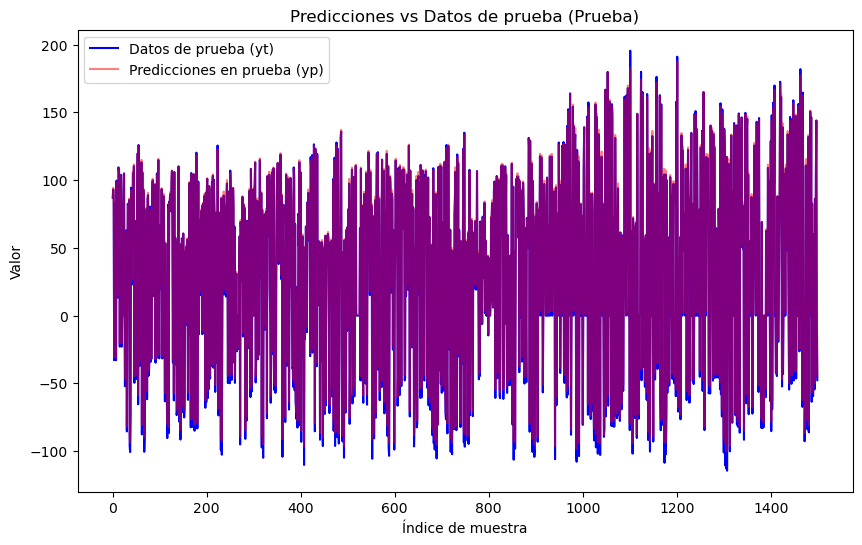

In [31]:
train_data = pd.read_csv("CNAVIA_train_corrected.csv")
test_data = pd.read_csv("CNAVIA_test.csv")

# Definir el tamaño de la ventana temporal (por ejemplo, 24 horas)
window_size = 24

# Función para preparar los datos para el modelo RNN
def prepare_data(data):
    # Ordenar los datos por fecha y hora
    data['fecha'] = pd.to_datetime(data['fecha'])
    data = data.sort_values(by='fecha')

    # Crear secuencias temporales deslizantes
    sequences = []
    for i in range(len(data) - window_size):
        sequence = data.iloc[i:i+window_size]
        sequences.append(sequence)

    # Crear conjuntos de características (X) y etiquetas (y) para cada secuencia temporal
    X = []
    y = []
    for sequence in sequences:
        X.append(sequence[['dia', 'mes', 'año', 'hora', 'consumo']].values)  # Tomar las características de día, mes, año, hora y consumo
        y.append(sequence.iloc[-1]['consumo'])  # Tomar el último valor de consumo como etiqueta de salida

    X = np.array(X)
    y = np.array(y)

    return X, y

# Preparar los datos de entrenamiento y prueba
X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

# Normalizar los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

# Reshape de los datos para que tengan la forma adecuada para LSTM
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], window_size, 5)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], window_size, 5)

# Construir el modelo RNN
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(window_size, 5)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compilar el modelo con el optimizador Adam y una tasa de aprendizaje de 1e-3
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo con 20 epochs
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=64, validation_data=(X_test_reshaped, y_test))

# Evaluar el modelo
loss = model.evaluate(X_test_reshaped, y_test)
print(f"Loss: {loss}")

# Obtener las predicciones en el conjunto de prueba
yp_test = model.predict(X_test_reshaped)

# Calcular las métricas adicionales: MSE, MAE 
mse = mean_squared_error(y_test, yp_test)
mae = mean_absolute_error(y_test, yp_test)
print(f"MSE: {mse}")
print(f"MAE: {mae}")
model.save("modelo_entrenado_CNAVIA.h5")
# Crear una secuencia de índices limitada para el conjunto de prueba (por ejemplo, las primeras 1500 muestras)
xw_test_limited = [i for i in range(1500)]

# Limitar las predicciones del conjunto de prueba a las primeras 1500 muestras
yp_test_limited = yp_test[:1500]

# Graficar los datos de prueba y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(xw_test_limited, y_test[:1500], label='Datos de prueba (yt)', color='blue')
plt.plot(xw_test_limited, yp_test_limited, label='Predicciones en prueba (yp)', color='red', alpha=0.5)  # Color rojo transparente
plt.xlabel('Índice de muestra')
plt.ylabel('Valor')
plt.title('Predicciones vs Datos de prueba (Prueba)')
plt.legend()
plt.show()

Epoch 1/20


C:\Users\luisa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2876/2876 ━━━━━━━━━━━━━━━━━━━━ 78s 25ms/step - loss: 5509.6787 - val_loss: 1735.1002
Epoch 2/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 76s 26ms/step - loss: 1774.4136 - val_loss: 1721.2186
Epoch 3/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 75s 26ms/step - loss: 1770.8754 - val_loss: 1721.2428
Epoch 4/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 75s 26ms/step - loss: 1774.5919 - val_loss: 1480.2565
Epoch 5/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 75s 26ms/step - loss: 736.8076 - val_loss: 61.4195
Epoch 6/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 76s 26ms/step - loss: 121.4427 - val_loss: 17.9084
Epoch 7/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 75s 26ms/step - loss: 88.4988 - val_loss: 16.2525
Epoch 8/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 75s 26ms/step - loss: 80.3532 - val_loss: 9.6404
Epoch 9/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 75s 26ms/step - loss: 74.4029 - val_loss: 6.7541
Epoch 10/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 77s 27ms/step - loss: 70.0400 - val_loss: 5.2440
Epoch 11/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 76s 26ms/step - loss: 68.5803 - 

MSE: 5.853660661406157
MAE: 1.5935734607328293


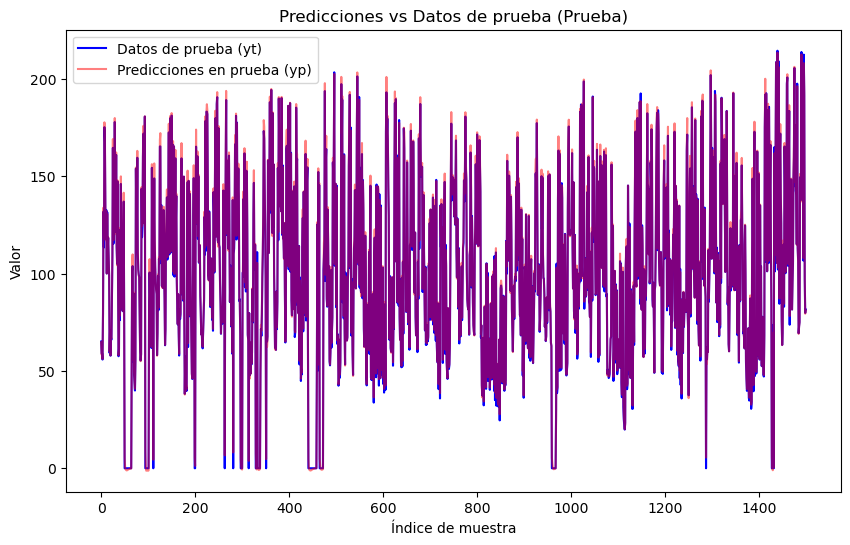

In [32]:
train_data = pd.read_csv("ELSALTO_train_corrected.csv")
test_data = pd.read_csv("ELSALTO_test.csv")

# Definir el tamaño de la ventana temporal (por ejemplo, 24 horas)
window_size = 24

# Función para preparar los datos para el modelo RNN
def prepare_data(data):
    # Ordenar los datos por fecha y hora
    data['fecha'] = pd.to_datetime(data['fecha'])
    data = data.sort_values(by='fecha')

    # Crear secuencias temporales deslizantes
    sequences = []
    for i in range(len(data) - window_size):
        sequence = data.iloc[i:i+window_size]
        sequences.append(sequence)

    # Crear conjuntos de características (X) y etiquetas (y) para cada secuencia temporal
    X = []
    y = []
    for sequence in sequences:
        X.append(sequence[['dia', 'mes', 'año', 'hora', 'consumo']].values)  # Tomar las características de día, mes, año, hora y consumo
        y.append(sequence.iloc[-1]['consumo'])  # Tomar el último valor de consumo como etiqueta de salida

    X = np.array(X)
    y = np.array(y)

    return X, y

# Preparar los datos de entrenamiento y prueba
X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

# Normalizar los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

# Reshape de los datos para que tengan la forma adecuada para LSTM
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], window_size, 5)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], window_size, 5)

# Construir el modelo RNN
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(window_size, 5)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compilar el modelo con el optimizador Adam y una tasa de aprendizaje de 1e-3
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo con 20 epochs
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=64, validation_data=(X_test_reshaped, y_test))

# Evaluar el modelo
loss = model.evaluate(X_test_reshaped, y_test)
print(f"Loss: {loss}")

# Obtener las predicciones en el conjunto de prueba
yp_test = model.predict(X_test_reshaped)

# Calcular las métricas adicionales: MSE, MAE 
mse = mean_squared_error(y_test, yp_test)
mae = mean_absolute_error(y_test, yp_test)
print(f"MSE: {mse}")
print(f"MAE: {mae}")
model.save("modelo_entrenado_ELSALTO.h5")
# Crear una secuencia de índices limitada para el conjunto de prueba (por ejemplo, las primeras 1500 muestras)
xw_test_limited = [i for i in range(1500)]

# Limitar las predicciones del conjunto de prueba a las primeras 1500 muestras
yp_test_limited = yp_test[:1500]

# Graficar los datos de prueba y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(xw_test_limited, y_test[:1500], label='Datos de prueba (yt)', color='blue')
plt.plot(xw_test_limited, yp_test_limited, label='Predicciones en prueba (yp)', color='red', alpha=0.5)  # Color rojo transparente
plt.xlabel('Índice de muestra')
plt.ylabel('Valor')
plt.title('Predicciones vs Datos de prueba (Prueba)')
plt.legend()
plt.show()

C:\Users\luisa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5751/5751 ━━━━━━━━━━━━━━━━━━━━ 156s 26ms/step - loss: 709.7340 - val_loss: 10.5222
Epoch 2/20
5751/5751 ━━━━━━━━━━━━━━━━━━━━ 147s 25ms/step - loss: 24.7112 - val_loss: 3.3825
Epoch 3/20
5751/5751 ━━━━━━━━━━━━━━━━━━━━ 153s 27ms/step - loss: 16.8722 - val_loss: 3.4324
Epoch 4/20
5751/5751 ━━━━━━━━━━━━━━━━━━━━ 152s 26ms/step - loss: 14.4080 - val_loss: 1.4183
Epoch 5/20
5751/5751 ━━━━━━━━━━━━━━━━━━━━ 159s 28ms/step - loss: 13.2203 - val_loss: 2.7965
Epoch 6/20
5751/5751 ━━━━━━━━━━━━━━━━━━━━ 153s 27ms/step - loss: 12.7390 - val_loss: 1.4466
Epoch 7/20
5751/5751 ━━━━━━━━━━━━━━━━━━━━ 159s 28ms/step - loss: 12.1680 - val_loss: 1.6139
Epoch 8/20
5751/5751 ━━━━━━━━━━━━━━━━━━━━ 158s 28ms/step - loss: 11.7882 - val_loss: 1.4012
Epoch 9/20
5751/5751 ━━━━━━━━━━━━━━━━━━━━ 155s 27ms/step - loss: 11.5062 - val_loss: 1.3844
Epoch 10/20
5751/5751 ━━━━━━━━━━━━━━━━━━━━ 154s 27ms/step - loss: 11.2267 - val_loss: 1.6101
Epoch 11/20
5751/5751 ━━━━━━━━━━━━━━━━━━━━ 171s 30ms/step - loss: 11.1019 - v

MSE: 1.047191940236544
MAE: 0.7759412074162766


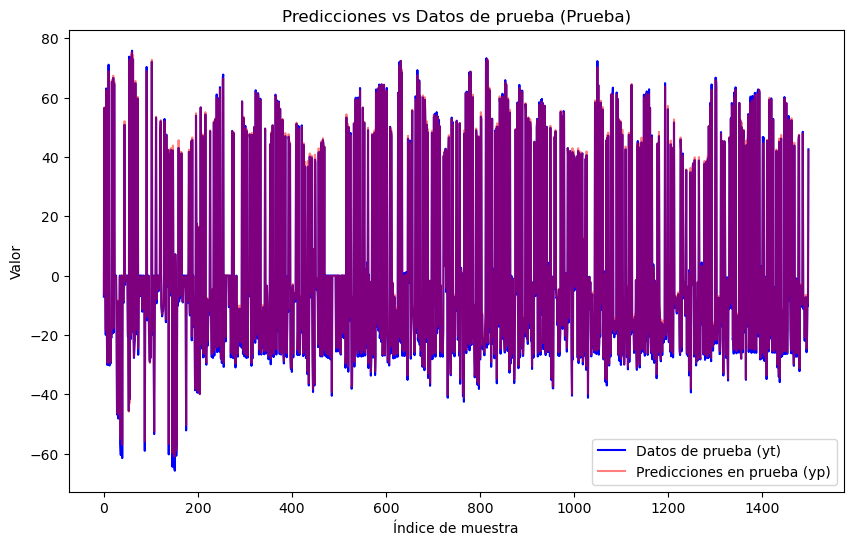

In [33]:
train_data = pd.read_csv("FLORIDA_train_corrected.csv")
test_data = pd.read_csv("FLORIDA_test.csv")

# Definir el tamaño de la ventana temporal (por ejemplo, 24 horas)
window_size = 24

# Función para preparar los datos para el modelo RNN
def prepare_data(data):
    # Ordenar los datos por fecha y hora
    data['fecha'] = pd.to_datetime(data['fecha'])
    data = data.sort_values(by='fecha')

    # Crear secuencias temporales deslizantes
    sequences = []
    for i in range(len(data) - window_size):
        sequence = data.iloc[i:i+window_size]
        sequences.append(sequence)

    # Crear conjuntos de características (X) y etiquetas (y) para cada secuencia temporal
    X = []
    y = []
    for sequence in sequences:
        X.append(sequence[['dia', 'mes', 'año', 'hora', 'consumo']].values)  # Tomar las características de día, mes, año, hora y consumo
        y.append(sequence.iloc[-1]['consumo'])  # Tomar el último valor de consumo como etiqueta de salida

    X = np.array(X)
    y = np.array(y)

    return X, y

# Preparar los datos de entrenamiento y prueba
X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

# Normalizar los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

# Reshape de los datos para que tengan la forma adecuada para LSTM
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], window_size, 5)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], window_size, 5)

# Construir el modelo RNN
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(window_size, 5)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compilar el modelo con el optimizador Adam y una tasa de aprendizaje de 1e-3
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo con 20 epochs
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=64, validation_data=(X_test_reshaped, y_test))

# Evaluar el modelo
loss = model.evaluate(X_test_reshaped, y_test)
print(f"Loss: {loss}")

# Obtener las predicciones en el conjunto de prueba
yp_test = model.predict(X_test_reshaped)

# Calcular las métricas adicionales: MSE, MAE 
mse = mean_squared_error(y_test, yp_test)
mae = mean_absolute_error(y_test, yp_test)
print(f"MSE: {mse}")
print(f"MAE: {mae}")
model.save("modelo_entrenado_FLORIDA.h5")
# Crear una secuencia de índices limitada para el conjunto de prueba (por ejemplo, las primeras 1500 muestras)
xw_test_limited = [i for i in range(1500)]

# Limitar las predicciones del conjunto de prueba a las primeras 1500 muestras
yp_test_limited = yp_test[:1500]

# Graficar los datos de prueba y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(xw_test_limited, y_test[:1500], label='Datos de prueba (yt)', color='blue')
plt.plot(xw_test_limited, yp_test_limited, label='Predicciones en prueba (yp)', color='red', alpha=0.5)  # Color rojo transparente
plt.xlabel('Índice de muestra')
plt.ylabel('Valor')
plt.title('Predicciones vs Datos de prueba (Prueba)')
plt.legend()
plt.show()

Epoch 1/20


C:\Users\luisa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2876/2876 ━━━━━━━━━━━━━━━━━━━━ 112s 37ms/step - loss: 1404.0518 - val_loss: 983.2076
Epoch 2/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 100s 35ms/step - loss: 994.5051 - val_loss: 983.2590
Epoch 3/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 103s 36ms/step - loss: 997.8461 - val_loss: 983.3504
Epoch 4/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 105s 37ms/step - loss: 986.5392 - val_loss: 983.2000
Epoch 5/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 108s 38ms/step - loss: 896.6174 - val_loss: 75.6650
Epoch 6/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 101s 35ms/step - loss: 110.5616 - val_loss: 34.2184
Epoch 7/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 100s 35ms/step - loss: 75.5500 - val_loss: 21.6775
Epoch 8/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 101s 35ms/step - loss: 59.7884 - val_loss: 16.2261
Epoch 9/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 100s 35ms/step - loss: 52.8794 - val_loss: 14.7877
Epoch 10/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 100s 35ms/step - loss: 46.3816 - val_loss: 11.6477
Epoch 11/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 100s 35ms/step - loss: 42.

MSE: 7.31312261526241
MAE: 1.8000164481170837


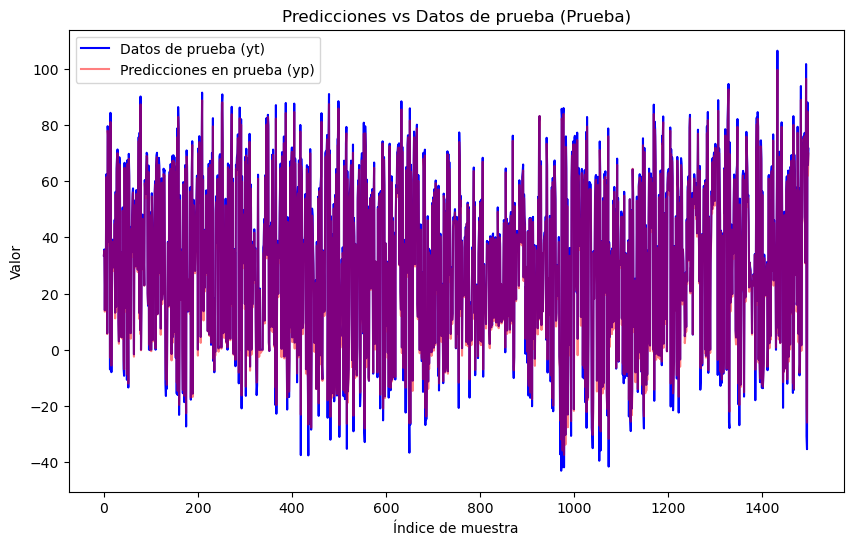

In [34]:
train_data = pd.read_csv("LOSALME_train_corrected.csv")
test_data = pd.read_csv("LOSALME_test.csv")

# Definir el tamaño de la ventana temporal (por ejemplo, 24 horas)
window_size = 24

# Función para preparar los datos para el modelo RNN
def prepare_data(data):
    # Ordenar los datos por fecha y hora
    data['fecha'] = pd.to_datetime(data['fecha'])
    data = data.sort_values(by='fecha')

    # Crear secuencias temporales deslizantes
    sequences = []
    for i in range(len(data) - window_size):
        sequence = data.iloc[i:i+window_size]
        sequences.append(sequence)

    # Crear conjuntos de características (X) y etiquetas (y) para cada secuencia temporal
    X = []
    y = []
    for sequence in sequences:
        X.append(sequence[['dia', 'mes', 'año', 'hora', 'consumo']].values)  # Tomar las características de día, mes, año, hora y consumo
        y.append(sequence.iloc[-1]['consumo'])  # Tomar el último valor de consumo como etiqueta de salida

    X = np.array(X)
    y = np.array(y)

    return X, y

# Preparar los datos de entrenamiento y prueba
X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

# Normalizar los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

# Reshape de los datos para que tengan la forma adecuada para LSTM
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], window_size, 5)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], window_size, 5)

# Construir el modelo RNN
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(window_size, 5)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compilar el modelo con el optimizador Adam y una tasa de aprendizaje de 1e-3
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo con 20 epochs
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=64, validation_data=(X_test_reshaped, y_test))

# Evaluar el modelo
loss = model.evaluate(X_test_reshaped, y_test)
print(f"Loss: {loss}")

# Obtener las predicciones en el conjunto de prueba
yp_test = model.predict(X_test_reshaped)

# Calcular las métricas adicionales: MSE, MAE 
mse = mean_squared_error(y_test, yp_test)
mae = mean_absolute_error(y_test, yp_test)
print(f"MSE: {mse}")
print(f"MAE: {mae}")
model.save("modelo_entrenado_LOSALMES.h5")
# Crear una secuencia de índices limitada para el conjunto de prueba (por ejemplo, las primeras 1500 muestras)
xw_test_limited = [i for i in range(1500)]

# Limitar las predicciones del conjunto de prueba a las primeras 1500 muestras
yp_test_limited = yp_test[:1500]

# Graficar los datos de prueba y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(xw_test_limited, y_test[:1500], label='Datos de prueba (yt)', color='blue')
plt.plot(xw_test_limited, yp_test_limited, label='Predicciones en prueba (yp)', color='red', alpha=0.5)  # Color rojo transparente
plt.xlabel('Índice de muestra')
plt.ylabel('Valor')
plt.title('Predicciones vs Datos de prueba (Prueba)')
plt.legend()
plt.show()

In [48]:
from tensorflow.keras.models import load_model
from sklearn.model_selection import TimeSeriesSplit
# Cargar el modelo entrenado previamente
model = load_model("modelo_entrenado_AJAHUEL.h5")

# Cargar los datos
data = pd.read_csv("AJAHUEL_test.csv")

# Definir las características (X) y las etiquetas (y)
X = data[['dia', 'mes', 'año', 'hora', 'consumo']]  # Ajusta las características según tus datos
y = data['consumo']

# Definir el tamaño de la ventana temporal
window_size = 24

# Truncar los datos de prueba para que el número total de muestras sea divisible por el tamaño de la ventana temporal
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
num_samples = len(X_scaled)
num_batches = num_samples // window_size
num_samples_new = num_batches * window_size
X_scaled = X_scaled[:num_samples_new]
y = y[:num_samples_new]

# Reshape de los datos para que tengan la forma adecuada para LSTM
X_reshaped = X_scaled.reshape(-1, window_size, 5)

# Definir el número de divisiones para la validación cruzada de series temporales
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Definir las listas para almacenar las métricas de evaluación
mse_scores = []
mae_scores = []

# Iterar sobre las divisiones de la validación cruzada
for train_index, test_index in tscv.split(X_reshaped):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test = X_reshaped[train_index], X_reshaped[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Evaluar el modelo en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Almacenar las métricas de evaluación
    mse_scores.append((mse_train, mse_test))
    mae_scores.append((mae_train, mae_test))

# Calcular el promedio de las métricas de evaluación de todas las divisiones de la validación cruzada
mse_train_avg = np.mean([mse_train for mse_train, _ in mse_scores])
mse_test_avg = np.mean([mse_test for _, mse_test in mse_scores])
mae_train_avg = np.mean([mae_train for mae_train, _ in mae_scores])
mae_test_avg = np.mean([mae_test for _, mae_test in mae_scores])

# Imprimir los resultados promedio
print("Promedio de MSE en entrenamiento:", mse_train_avg)
print("Promedio de MSE en prueba:", mse_test_avg)
print("Promedio de MAE en entrenamiento:", mae_train_avg)
print("Promedio de MAE en prueba:", mae_test_avg)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Promedio de MSE en entrenamiento: 10168.25484951396
Promedio de MSE en prueba: 10468.718190670783
Promedio de MAE en entrenamiento: 84.37541221955544
Promedio de MAE en prueba: 86.09305355322664


In [49]:
from tensorflow.keras.models import load_model
from sklearn.model_selection import TimeSeriesSplit
# Cargar el modelo entrenado previamente
model = load_model("modelo_entrenado_BUIN.h5")

# Cargar los datos
data = pd.read_csv("BUIN_test.csv")

# Definir las características (X) y las etiquetas (y)
X = data[['dia', 'mes', 'año', 'hora', 'consumo']]  # Ajusta las características según tus datos
y = data['consumo']

# Definir el tamaño de la ventana temporal
window_size = 24

# Truncar los datos de prueba para que el número total de muestras sea divisible por el tamaño de la ventana temporal
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
num_samples = len(X_scaled)
num_batches = num_samples // window_size
num_samples_new = num_batches * window_size
X_scaled = X_scaled[:num_samples_new]
y = y[:num_samples_new]

# Reshape de los datos para que tengan la forma adecuada para LSTM
X_reshaped = X_scaled.reshape(-1, window_size, 5)

# Definir el número de divisiones para la validación cruzada de series temporales
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Definir las listas para almacenar las métricas de evaluación
mse_scores = []
mae_scores = []

# Iterar sobre las divisiones de la validación cruzada
for train_index, test_index in tscv.split(X_reshaped):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test = X_reshaped[train_index], X_reshaped[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Evaluar el modelo en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Almacenar las métricas de evaluación
    mse_scores.append((mse_train, mse_test))
    mae_scores.append((mae_train, mae_test))

# Calcular el promedio de las métricas de evaluación de todas las divisiones de la validación cruzada
mse_train_avg = np.mean([mse_train for mse_train, _ in mse_scores])
mse_test_avg = np.mean([mse_test for _, mse_test in mse_scores])
mae_train_avg = np.mean([mae_train for mae_train, _ in mae_scores])
mae_test_avg = np.mean([mae_test for _, mae_test in mae_scores])

# Imprimir los resultados promedio
print("Promedio de MSE en entrenamiento:", mse_train_avg)
print("Promedio de MSE en prueba:", mse_test_avg)
print("Promedio de MAE en entrenamiento:", mae_train_avg)
print("Promedio de MAE en prueba:", mae_test_avg)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Promedio de MSE en entrenamiento: 17670.241758995246
Promedio de MSE en prueba: 17414.044415497792
Promedio de MAE en entrenamiento: 99.2973009783851
Promedio de MAE en prueba: 98.60388266405532


In [50]:
from tensorflow.keras.models import load_model
from sklearn.model_selection import TimeSeriesSplit
# Cargar el modelo entrenado previamente
model = load_model("modelo_entrenado_CHENA.h5")

# Cargar los datos
data = pd.read_csv("CHENA_test.csv")

# Definir las características (X) y las etiquetas (y)
X = data[['dia', 'mes', 'año', 'hora', 'consumo']]  # Ajusta las características según tus datos
y = data['consumo']

# Definir el tamaño de la ventana temporal
window_size = 24

# Truncar los datos de prueba para que el número total de muestras sea divisible por el tamaño de la ventana temporal
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
num_samples = len(X_scaled)
num_batches = num_samples // window_size
num_samples_new = num_batches * window_size
X_scaled = X_scaled[:num_samples_new]
y = y[:num_samples_new]

# Reshape de los datos para que tengan la forma adecuada para LSTM
X_reshaped = X_scaled.reshape(-1, window_size, 5)

# Definir el número de divisiones para la validación cruzada de series temporales
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Definir las listas para almacenar las métricas de evaluación
mse_scores = []
mae_scores = []

# Iterar sobre las divisiones de la validación cruzada
for train_index, test_index in tscv.split(X_reshaped):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test = X_reshaped[train_index], X_reshaped[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Evaluar el modelo en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Almacenar las métricas de evaluación
    mse_scores.append((mse_train, mse_test))
    mae_scores.append((mae_train, mae_test))

# Calcular el promedio de las métricas de evaluación de todas las divisiones de la validación cruzada
mse_train_avg = np.mean([mse_train for mse_train, _ in mse_scores])
mse_test_avg = np.mean([mse_test for _, mse_test in mse_scores])
mae_train_avg = np.mean([mae_train for mae_train, _ in mae_scores])
mae_test_avg = np.mean([mae_test for _, mae_test in mae_scores])

# Imprimir los resultados promedio
print("Promedio de MSE en entrenamiento:", mse_train_avg)
print("Promedio de MSE en prueba:", mse_test_avg)
print("Promedio de MAE en entrenamiento:", mae_train_avg)
print("Promedio de MAE en prueba:", mae_test_avg)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Promedio de MSE en entrenamiento: 23613.517126974995
Promedio de MSE en prueba: 23315.561576445525
Promedio de MAE en entrenamiento: 114.55278367693934
Promedio de MAE en prueba: 112.76483284385452


In [51]:
from tensorflow.keras.models import load_model
from sklearn.model_selection import TimeSeriesSplit
# Cargar el modelo entrenado previamente
model = load_model("modelo_entrenado_CNAVIA.h5")

# Cargar los datos
data = pd.read_csv("CNAVIA_test.csv")

# Definir las características (X) y las etiquetas (y)
X = data[['dia', 'mes', 'año', 'hora', 'consumo']]  # Ajusta las características según tus datos
y = data['consumo']

# Definir el tamaño de la ventana temporal
window_size = 24

# Truncar los datos de prueba para que el número total de muestras sea divisible por el tamaño de la ventana temporal
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
num_samples = len(X_scaled)
num_batches = num_samples // window_size
num_samples_new = num_batches * window_size
X_scaled = X_scaled[:num_samples_new]
y = y[:num_samples_new]

# Reshape de los datos para que tengan la forma adecuada para LSTM
X_reshaped = X_scaled.reshape(-1, window_size, 5)

# Definir el número de divisiones para la validación cruzada de series temporales
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Definir las listas para almacenar las métricas de evaluación
mse_scores = []
mae_scores = []

# Iterar sobre las divisiones de la validación cruzada
for train_index, test_index in tscv.split(X_reshaped):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test = X_reshaped[train_index], X_reshaped[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Evaluar el modelo en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Almacenar las métricas de evaluación
    mse_scores.append((mse_train, mse_test))
    mae_scores.append((mae_train, mae_test))

# Calcular el promedio de las métricas de evaluación de todas las divisiones de la validación cruzada
mse_train_avg = np.mean([mse_train for mse_train, _ in mse_scores])
mse_test_avg = np.mean([mse_test for _, mse_test in mse_scores])
mae_train_avg = np.mean([mae_train for mae_train, _ in mae_scores])
mae_test_avg = np.mean([mae_test for _, mae_test in mae_scores])

# Imprimir los resultados promedio
print("Promedio de MSE en entrenamiento:", mse_train_avg)
print("Promedio de MSE en prueba:", mse_test_avg)
print("Promedio de MAE en entrenamiento:", mae_train_avg)
print("Promedio de MAE en prueba:", mae_test_avg)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Promedio de MSE en entrenamiento: 6325.6458393994135
Promedio de MSE en prueba: 6313.278650650007
Promedio de MAE en entrenamiento: 61.922654725191116
Promedio de MAE en prueba: 62.19541100714523


In [52]:
from tensorflow.keras.models import load_model
from sklearn.model_selection import TimeSeriesSplit
# Cargar el modelo entrenado previamente
model = load_model("modelo_entrenado_ELSALTO.h5")

# Cargar los datos
data = pd.read_csv("ELSALTO_test.csv")

# Definir las características (X) y las etiquetas (y)
X = data[['dia', 'mes', 'año', 'hora', 'consumo']]  # Ajusta las características según tus datos
y = data['consumo']

# Definir el tamaño de la ventana temporal
window_size = 24

# Truncar los datos de prueba para que el número total de muestras sea divisible por el tamaño de la ventana temporal
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
num_samples = len(X_scaled)
num_batches = num_samples // window_size
num_samples_new = num_batches * window_size
X_scaled = X_scaled[:num_samples_new]
y = y[:num_samples_new]

# Reshape de los datos para que tengan la forma adecuada para LSTM
X_reshaped = X_scaled.reshape(-1, window_size, 5)

# Definir el número de divisiones para la validación cruzada de series temporales
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Definir las listas para almacenar las métricas de evaluación
mse_scores = []
mae_scores = []

# Iterar sobre las divisiones de la validación cruzada
for train_index, test_index in tscv.split(X_reshaped):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test = X_reshaped[train_index], X_reshaped[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Evaluar el modelo en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Almacenar las métricas de evaluación
    mse_scores.append((mse_train, mse_test))
    mae_scores.append((mae_train, mae_test))

# Calcular el promedio de las métricas de evaluación de todas las divisiones de la validación cruzada
mse_train_avg = np.mean([mse_train for mse_train, _ in mse_scores])
mse_test_avg = np.mean([mse_test for _, mse_test in mse_scores])
mae_train_avg = np.mean([mae_train for mae_train, _ in mae_scores])
mae_test_avg = np.mean([mae_test for _, mae_test in mae_scores])

# Imprimir los resultados promedio
print("Promedio de MSE en entrenamiento:", mse_train_avg)
print("Promedio de MSE en prueba:", mse_test_avg)
print("Promedio de MAE en entrenamiento:", mae_train_avg)
print("Promedio de MAE en prueba:", mae_test_avg)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Promedio de MSE en entrenamiento: 3543.6488268238054
Promedio de MSE en prueba: 3430.962155293947
Promedio de MAE en entrenamiento: 47.591181417573935
Promedio de MAE en prueba: 46.01873716279462


In [53]:
from tensorflow.keras.models import load_model
from sklearn.model_selection import TimeSeriesSplit
# Cargar el modelo entrenado previamente
model = load_model("modelo_entrenado_FLORIDA.h5")

# Cargar los datos
data = pd.read_csv("FLORIDA_test.csv")

# Definir las características (X) y las etiquetas (y)
X = data[['dia', 'mes', 'año', 'hora', 'consumo']]  # Ajusta las características según tus datos
y = data['consumo']

# Definir el tamaño de la ventana temporal
window_size = 24

# Truncar los datos de prueba para que el número total de muestras sea divisible por el tamaño de la ventana temporal
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
num_samples = len(X_scaled)
num_batches = num_samples // window_size
num_samples_new = num_batches * window_size
X_scaled = X_scaled[:num_samples_new]
y = y[:num_samples_new]

# Reshape de los datos para que tengan la forma adecuada para LSTM
X_reshaped = X_scaled.reshape(-1, window_size, 5)

# Definir el número de divisiones para la validación cruzada de series temporales
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Definir las listas para almacenar las métricas de evaluación
mse_scores = []
mae_scores = []

# Iterar sobre las divisiones de la validación cruzada
for train_index, test_index in tscv.split(X_reshaped):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test = X_reshaped[train_index], X_reshaped[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Evaluar el modelo en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Almacenar las métricas de evaluación
    mse_scores.append((mse_train, mse_test))
    mae_scores.append((mae_train, mae_test))

# Calcular el promedio de las métricas de evaluación de todas las divisiones de la validación cruzada
mse_train_avg = np.mean([mse_train for mse_train, _ in mse_scores])
mse_test_avg = np.mean([mse_test for _, mse_test in mse_scores])
mae_train_avg = np.mean([mae_train for mae_train, _ in mae_scores])
mae_test_avg = np.mean([mae_test for _, mae_test in mae_scores])

# Imprimir los resultados promedio
print("Promedio de MSE en entrenamiento:", mse_train_avg)
print("Promedio de MSE en prueba:", mse_test_avg)
print("Promedio de MAE en entrenamiento:", mae_train_avg)
print("Promedio de MAE en prueba:", mae_test_avg)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Promedio de MSE en entrenamiento: 1836.8066438191497
Promedio de MSE en prueba: 1916.6642212953018
Promedio de MAE en entrenamiento: 33.75918519530387
Promedio de MAE en prueba: 34.420343684903415


In [46]:
from tensorflow.keras.models import load_model
from sklearn.model_selection import TimeSeriesSplit
# Cargar el modelo entrenado previamente
model = load_model("modelo_entrenado_LOSALMES.h5")

# Cargar los datos
data = pd.read_csv("LOSALME_test.csv")

# Definir las características (X) y las etiquetas (y)
X = data[['dia', 'mes', 'año', 'hora', 'consumo']]  # Ajusta las características según tus datos
y = data['consumo']

# Definir el tamaño de la ventana temporal
window_size = 24

# Truncar los datos de prueba para que el número total de muestras sea divisible por el tamaño de la ventana temporal
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
num_samples = len(X_scaled)
num_batches = num_samples // window_size
num_samples_new = num_batches * window_size
X_scaled = X_scaled[:num_samples_new]
y = y[:num_samples_new]

# Reshape de los datos para que tengan la forma adecuada para LSTM
X_reshaped = X_scaled.reshape(-1, window_size, 5)

# Definir el número de divisiones para la validación cruzada de series temporales
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Definir las listas para almacenar las métricas de evaluación
mse_scores = []
mae_scores = []

# Iterar sobre las divisiones de la validación cruzada
for train_index, test_index in tscv.split(X_reshaped):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test = X_reshaped[train_index], X_reshaped[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Evaluar el modelo en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Almacenar las métricas de evaluación
    mse_scores.append((mse_train, mse_test))
    mae_scores.append((mae_train, mae_test))

# Calcular el promedio de las métricas de evaluación de todas las divisiones de la validación cruzada
mse_train_avg = np.mean([mse_train for mse_train, _ in mse_scores])
mse_test_avg = np.mean([mse_test for _, mse_test in mse_scores])
mae_train_avg = np.mean([mae_train for mae_train, _ in mae_scores])
mae_test_avg = np.mean([mae_test for _, mae_test in mae_scores])

# Imprimir los resultados promedio
print("Promedio de MSE en entrenamiento:", mse_train_avg)
print("Promedio de MSE en prueba:", mse_test_avg)
print("Promedio de MAE en entrenamiento:", mae_train_avg)
print("Promedio de MAE en prueba:", mae_test_avg)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Promedio de MSE en entrenamiento: 1862.8131881622617
Promedio de MSE en prueba: 1968.0983168651946
Promedio de MAE en entrenamiento: 34.00335385328998
Promedio de MAE en prueba: 35.15258428779178


In [59]:
# Cargar el modelo entrenado previamente
model = load_model("modelo_entrenado_AJAHUEL.h5")

# Mostrar la descripción de la arquitectura del modelo
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,653 (201.77 KB)

 Trainable params: 51,651 (201.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [60]:
# Cargar el modelo entrenado previamente
model = load_model("modelo_entrenado_BUIN.h5")

# Mostrar la descripción de la arquitectura del modelo
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 24, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,653 (201.77 KB)

 Trainable params: 51,651 (201.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [66]:
# Cargar el modelo entrenado previamente
model = load_model("modelo_entrenado_CHENA.h5")

# Mostrar la descripción de la arquitectura del modelo
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 24, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,653 (201.77 KB)

 Trainable params: 51,651 (201.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [62]:
# Cargar el modelo entrenado previamente
model = load_model("modelo_entrenado_CNAVIA.h5")

# Mostrar la descripción de la arquitectura del modelo
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 24, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,653 (201.77 KB)

 Trainable params: 51,651 (201.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [63]:
# Cargar el modelo entrenado previamente
model = load_model("modelo_entrenado_ELSALTO.h5")

# Mostrar la descripción de la arquitectura del modelo
print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 24, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,653 (201.77 KB)

 Trainable params: 51,651 (201.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [64]:
# Cargar el modelo entrenado previamente
model = load_model("modelo_entrenado_FLORIDA.h5")

# Mostrar la descripción de la arquitectura del modelo
print(model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 24, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,653 (201.77 KB)

 Trainable params: 51,651 (201.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [67]:
# Cargar el modelo entrenado previamente
model = load_model("modelo_entrenado_LOSALMES.h5")

# Mostrar la descripción de la arquitectura del modelo
print(model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 24, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,653 (201.77 KB)

 Trainable params: 51,651 (201.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
